Work In Progress notebook to integrate the mouse organoid data with Joanito et al. aggregate dataset of CRC cohorts.
The resulting integrated object is available upon request due to to size limitations.

In [1]:
import scanpy as sc
import scvi
import anndata as ad
import numpy as np
import pandas as pd
import seaborn as sns

Global seed set to 0
/var/home/ferran/miniconda3/envs/scvi-env/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import phate
phate_operator = phate.PHATE(n_jobs=-2, random_state=12)

In [ ]:
humanData = sc.read_h5ad("../OnRequest/epi_iCMSh.h5ad")
mouseData = sc.read_h5ad("../OnRequest/epi_CRCTMEh.h5ad")

In [ ]:
intData = sc.read_h5ad("../OnRequest/epi_INT.h5ad")

# Joanito et al. CRC data

In [3]:
humanData = sc.read_h5ad("../OnRequest/Epithelial_Count_matrix.h5ad").transpose()
humanData.obs = pd.read_csv("../OnRequest/Epithelial_metadata.csv", index_col="cell.ID")
sc.pp.filter_genes(humanData, min_counts=3)
humanData.layers["counts"] = humanData.X.copy()  # preserve counts
sc.pp.normalize_total(humanData, target_sum=1e4)
sc.pp.log1p(humanData, base=2)
humanData.raw = humanData  # freeze the state in `.raw`
sc.pp.highly_variable_genes(
    humanData,
    n_top_genes=6000,
    subset=True,
    layer="counts",
    flavor="seurat_v3"
)

In [12]:
print(humanData.X.min(), humanData.X.mean(), humanData.X.max())

0.0 0.23635823 12.428172


In [4]:
scvi.model.SCVI.setup_anndata(
    humanData,
    layer="counts",
    batch_key="patient.ID",
    # categorical_covariate_keys=["sample.ID", "dataset"],
    continuous_covariate_keys=["percent.mt"],
)
arches_params = dict(
    use_layer_norm="both",
    use_batch_norm="none",
    encode_covariates=True,
    dropout_rate=0.2,
    n_layers=2,
)
vae_ref = scvi.model.SCVI(humanData, **arches_params)
vae_ref.train()

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 163/163: 100%|██████████| 163/163 [17:01<00:00,  6.17s/it, loss=2.77e+03, v_num=1]

`Trainer.fit` stopped: `max_epochs=163` reached.


Epoch 163/163: 100%|██████████| 163/163 [17:01<00:00,  6.27s/it, loss=2.77e+03, v_num=1]


In [5]:
humanData.obsm["X_scVI"] = vae_ref.get_latent_representation()
# sc.tl.pca(adata)
# sc.pp.neighbors(adata, n_pcs=30, n_neighbors=20)
# sc.tl.umap(adata, min_dist=0.3)
sc.pp.neighbors(humanData, use_rep="X_scVI")
sc.tl.umap(humanData, min_dist=0.3)
phate_data = phate_operator.fit_transform(humanData.obsm["X_scVI"])
humanData.obsm["X_phateINT"] = phate_data

/var/home/ferran/miniconda3/envs/scvi-env/lib/python3.9/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/var/home/ferran/miniconda3/envs/scvi-env/lib/python3.9/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/var/home/ferran/miniconda3/envs/scvi-env/lib/python3.9/si

Calculating PHATE...
  Running PHATE on 49155 observations and 10 variables.
  Calculating graph and diffusion operator...
    Calculating KNN search...
    Calculated KNN search in 67.46 seconds.
    Calculating affinities...
    Calculated affinities in 0.39 seconds.
  Calculated graph and diffusion operator in 67.91 seconds.
  Calculating landmark operator...
    Calculating SVD...
    Calculated SVD in 6.32 seconds.
    Calculating KMeans...
    Calculated KMeans in 6.61 seconds.
  Calculated landmark operator in 15.96 seconds.
  Calculating optimal t...
    Automatically selected t = 32
  Calculated optimal t in 3.18 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 0.59 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 9.35 seconds.
Calculated PHATE in 97.01 seconds.


/var/home/ferran/miniconda3/envs/scvi-env/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


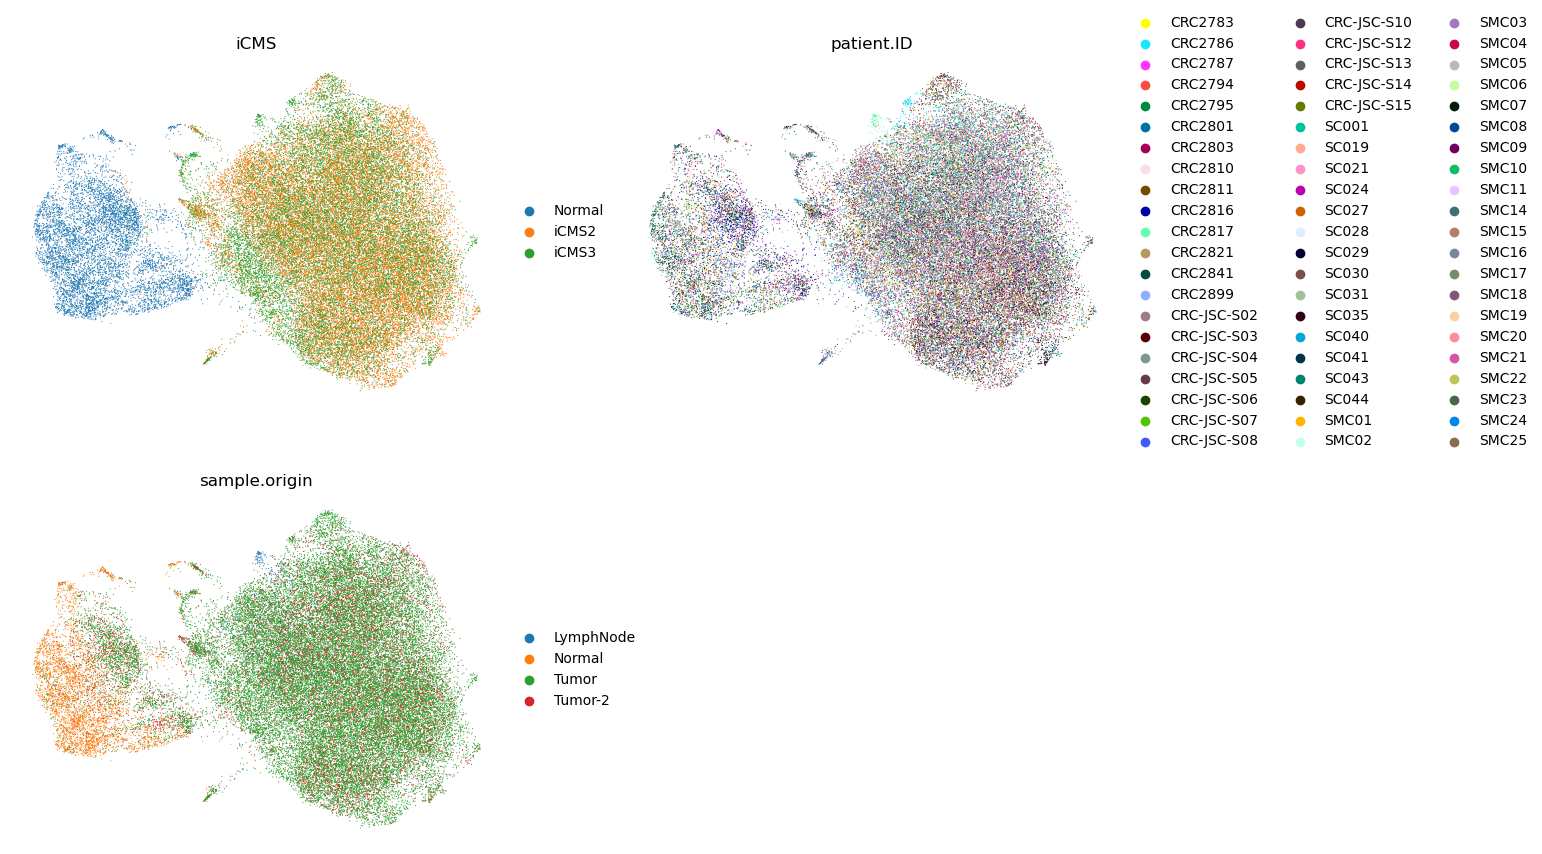

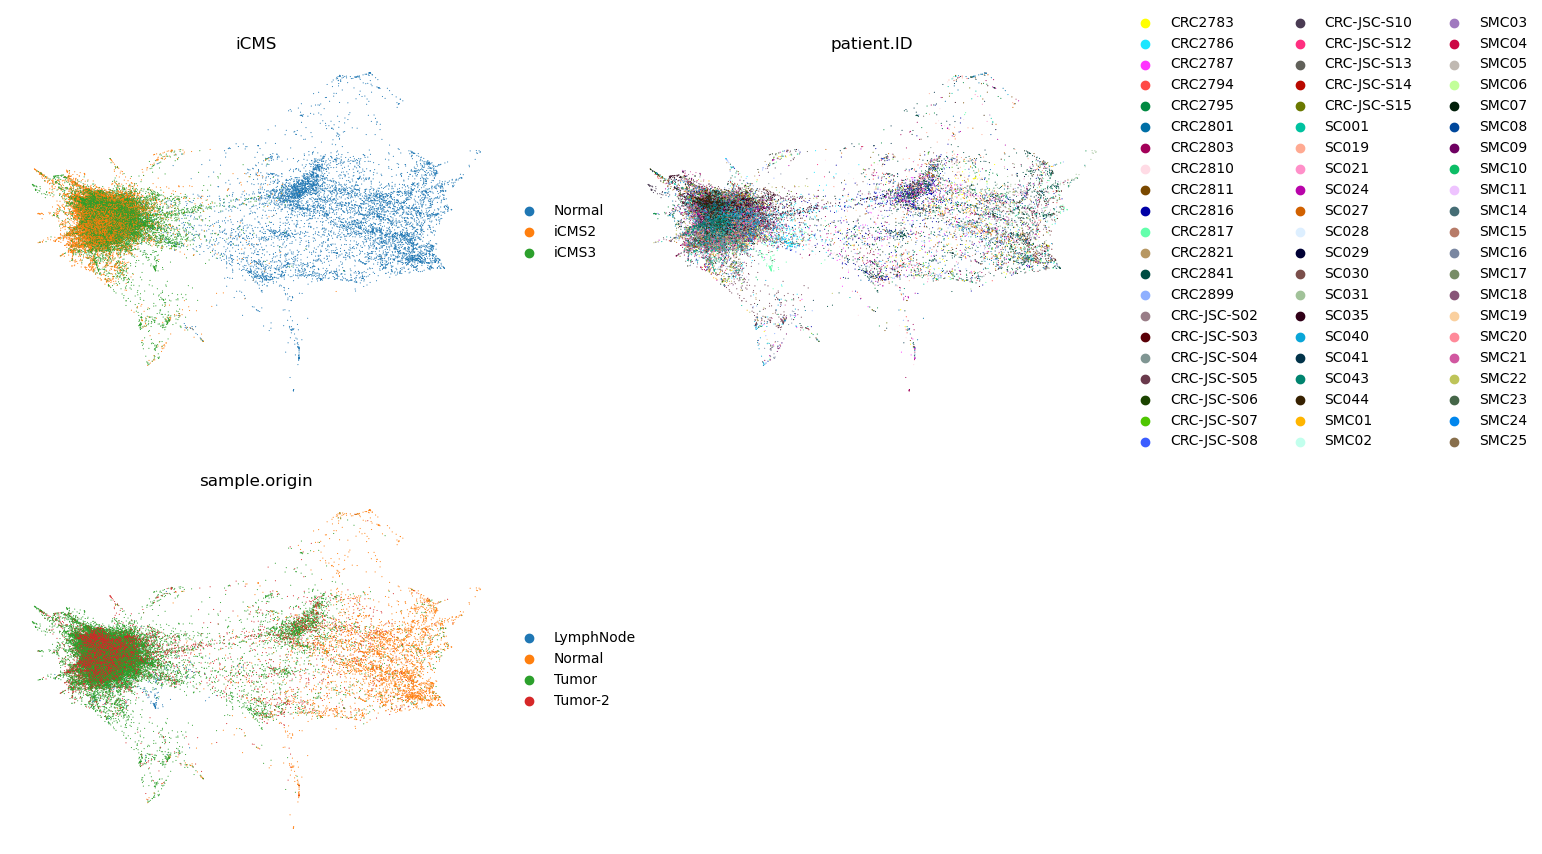

In [6]:
sc.pl.umap(
    humanData,
    color=["iCMS","patient.ID", "sample.origin"],
    ncols=2,
    frameon=False,
)
sc.pl.embedding(humanData, basis="X_phateINT", 
                color = ["iCMS","patient.ID", "sample.origin"],
                ncols=2,
                frameon=False)

In [17]:
print(humanData)

AnnData object with n_obs × n_vars = 49155 × 6000
    obs: 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'sample.ID', 'patient.ID', 'sample.origin', 'dataset', 'cell.type', 'iCMS', 'msi', '_scvi_batch', '_scvi_labels'
    var: 'n_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'log1p', 'hvg', '_scvi_uuid', '_scvi_manager_uuid', 'neighbors', 'umap', 'iCMS_colors', 'patient.ID_colors', 'sample.origin_colors'
    obsm: '_scvi_extra_continuous_covs', 'X_scVI', 'X_umap', 'X_phateINT'
    layers: 'counts'
    obsp: 'distances', 'connectivities'


In [55]:
humanData = sc.read_h5ad("../OnRequest/epi_iCMSh.h5ad")

# Qin & Cardoso Rodriguez murine organoid data

In [4]:
mouseData = ad.read_csv("../OnRequest/INTepi_counts.csv").transpose()
from scipy.sparse import csr_matrix
mouseData.X = csr_matrix(mouseData.X)

In [5]:
#Ensure right index
mouseData.obs = pd.read_csv("../OnRequest/INTepi_meta.csv", index_col=0)[["nCount_RNA", "nFeature_RNA","mito_content","experiment","orig_ident","CRCTME","Genotype","curatedCLUST","SCENT_ccat","velocity_length"]]
#Ensure obsm have the right index, otherwise, issues with dataframes down the line.
mouseData.obsm["X_OGphate"] = pd.read_csv("data/INTepi_phate.csv", index_col=0)

/var/home/ferran/miniconda3/envs/scvi-env/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3508: DtypeWarning: Columns (12,17,31) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


Humanise features with the mousipy package

In [ ]:
from mousipy import translate

mouseData = translate(mouseData)

  0%|          | 0/27434 [00:00<?, ?it/s]

100%|██████████| 27434/27434 [00:25<00:00, 1061.33it/s]


Found direct orthologs for 15361 genes.
Found multiple orthologs for 444 genes.
Found no orthologs for 11181 genes.
Found no index in biomart for 448 genes.


100%|██████████| 444/444 [09:59<00:00,  1.35s/it]
/var/home/ferran/miniconda3/envs/scvi-env/lib/python3.9/site-packages/anndata/_core/anndata.py:1832: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [8]:
print(mouseData.X.min(), mouseData.X.mean(),mouseData.X.max())
sc.pp.filter_genes(mouseData, min_counts=3)
mouseData.layers["counts"] = mouseData.X.copy()  # preserve counts
sc.pp.normalize_total(mouseData, target_sum=1e4)
sc.pp.log1p(mouseData, base=2)
mouseData.raw = mouseData  # freeze the state in `.raw`
print(mouseData.X.min(), mouseData.X.mean(),mouseData.X.max())

0.0 1.4873352 11563.0
0.0 0.32993072 11.990791


In [10]:
mouseData = sc.read_h5ad("../OnRequest/epi_CRCTMEh.h5ad")

In [11]:
print(mouseData)

AnnData object with n_obs × n_vars = 29254 × 15107
    obs: 'nCount_RNA', 'nFeature_RNA', 'mito_content', 'experiment', 'orig_ident', 'CRCTME', 'Genotype', 'curatedCLUST', 'SCENT_ccat', 'velocity_length'
    var: 'original_gene_symbol', 'n_counts'
    uns: 'log1p'
    obsm: 'X_OGphate'
    layers: 'counts'


In [12]:
print(humanData.var_names)
print(mouseData.var_names)

Index(['AL645608.1', 'SAMD11', 'HES4', 'ISG15', 'AGRN', 'TNFRSF18', 'TNFRSF4',
       'C1QTNF12', 'MXRA8', 'ANKRD65',
       ...
       'COL6A2', 'FTCD', 'LSS', 'C21orf58', 'S100B', 'AC141272.1',
       'AC007325.2', 'AC004556.1', 'AC233755.2', 'AC233755.1'],
      dtype='object', length=6000)
Index(['MRPL15', 'LYPLA1', 'TCEA1', 'RGS20', 'ATP6V1H', 'RB1CC1', 'PCMTD1',
       'RRS1', 'ADHFE1', 'MYBL1',
       ...
       'FAM90A23P', 'FAM90A19P', 'FAM90A14P', 'FAM90A18P', 'FAM90A10P',
       'FAM90A17P', 'FAM90A16P', 'IGHA1', 'IGHA2', 'KISS1'],
      dtype='object', length=15107)


# Reference Mapping

In [13]:
scvi.model.SCVI.prepare_query_anndata(mouseData, "humanREF_model/")

INFO     File humanREF_model/model.pt already downloaded                                                           
INFO     Found 62.64999999999999% reference vars in query data.                                                    


/var/home/ferran/miniconda3/envs/scvi-env/lib/python3.9/site-packages/scvi/model/base/_archesmixin.py:202: UserWarning: Query data contains less than 80% of reference var names. This may result in poor performance.
  warnings.warn(
/var/home/ferran/miniconda3/envs/scvi-env/lib/python3.9/site-packages/anndata/_core/merge.py:1111: UserWarning: Only some AnnData objects have `.raw` attribute, not concatenating `.raw` attributes.
  warn(


In [14]:
print(humanData.var_names)
print(mouseData.var_names)

Index(['AL645608.1', 'SAMD11', 'HES4', 'ISG15', 'AGRN', 'TNFRSF18', 'TNFRSF4',
       'C1QTNF12', 'MXRA8', 'ANKRD65',
       ...
       'COL6A2', 'FTCD', 'LSS', 'C21orf58', 'S100B', 'AC141272.1',
       'AC007325.2', 'AC004556.1', 'AC233755.2', 'AC233755.1'],
      dtype='object', length=6000)
Index(['AL645608.1', 'SAMD11', 'HES4', 'ISG15', 'AGRN', 'TNFRSF18', 'TNFRSF4',
       'C1QTNF12', 'MXRA8', 'ANKRD65',
       ...
       'COL6A2', 'FTCD', 'LSS', 'C21orf58', 'S100B', 'AC141272.1',
       'AC007325.2', 'AC004556.1', 'AC233755.2', 'AC233755.1'],
      dtype='object', length=6000)


In [15]:
mouseData.obs = mouseData.obs.rename(columns={"mito_content":"percent.mt", "orig_ident":"sample.ID"})

Orig ident / sample.ID as batch

INFO     File humanREF_model/model.pt already downloaded                                                           


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 200/200: 100%|██████████| 200/200 [09:45<00:00,  2.73s/it, loss=3.95e+03, v_num=1]

`Trainer.fit` stopped: `max_epochs=200` reached.


Epoch 200/200: 100%|██████████| 200/200 [09:45<00:00,  2.93s/it, loss=3.95e+03, v_num=1]


/var/home/ferran/miniconda3/envs/scvi-env/lib/python3.9/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/var/home/ferran/miniconda3/envs/scvi-env/lib/python3.9/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/var/home/ferran/miniconda3/envs/scvi-env/lib/python3.9/si

Calculating PHATE...
  Running PHATE on 29254 observations and 10 variables.
  Calculating graph and diffusion operator...
    Calculating KNN search...
    Calculated KNN search in 14.48 seconds.
    Calculating affinities...
    Calculated affinities in 0.14 seconds.
  Calculated graph and diffusion operator in 14.65 seconds.
  Calculating landmark operator...
    Calculating SVD...
    Calculated SVD in 1.81 seconds.
    Calculating KMeans...
    Calculated KMeans in 6.94 seconds.
  Calculated landmark operator in 10.18 seconds.
  Calculating optimal t...
    Automatically selected t = 27
  Calculated optimal t in 1.77 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 0.56 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 5.14 seconds.
Calculated PHATE in 32.31 seconds.


/var/home/ferran/miniconda3/envs/scvi-env/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


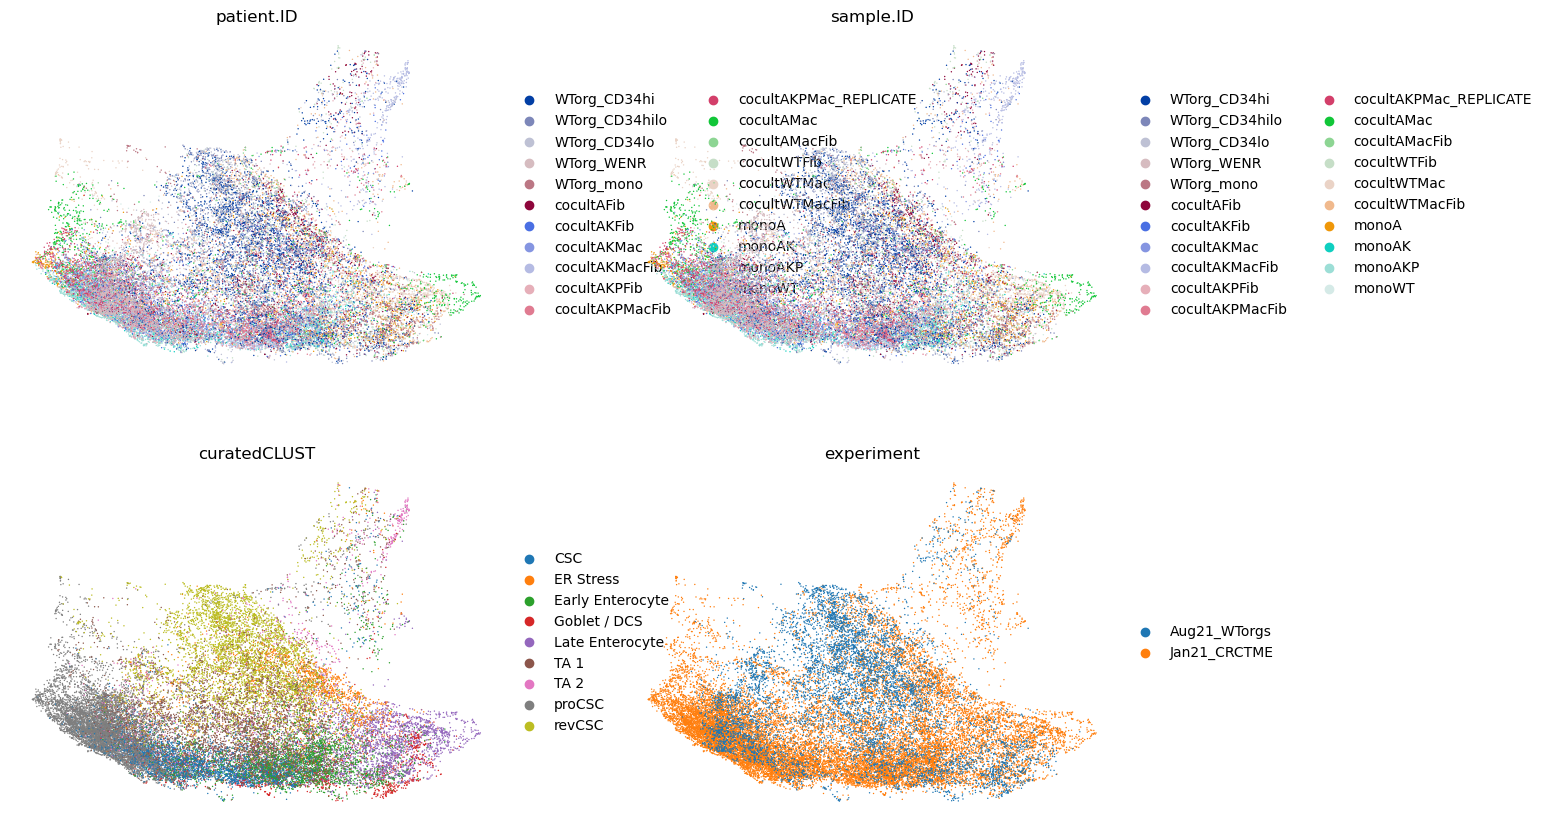

/var/home/ferran/miniconda3/envs/scvi-env/lib/python3.9/site-packages/anndata/_core/anndata.py:1755: FutureWarning: The AnnData.concatenate method is deprecated in favour of the anndata.concat function. Please use anndata.concat instead.

See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  warnings.warn(


INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/var/home/ferran/miniconda3/envs/scvi-env/lib/python3.9/site-packages/anndata/_core/merge.py:1111: UserWarning: Only some AnnData objects have `.raw` attribute, not concatenating `.raw` attributes.
  warn(


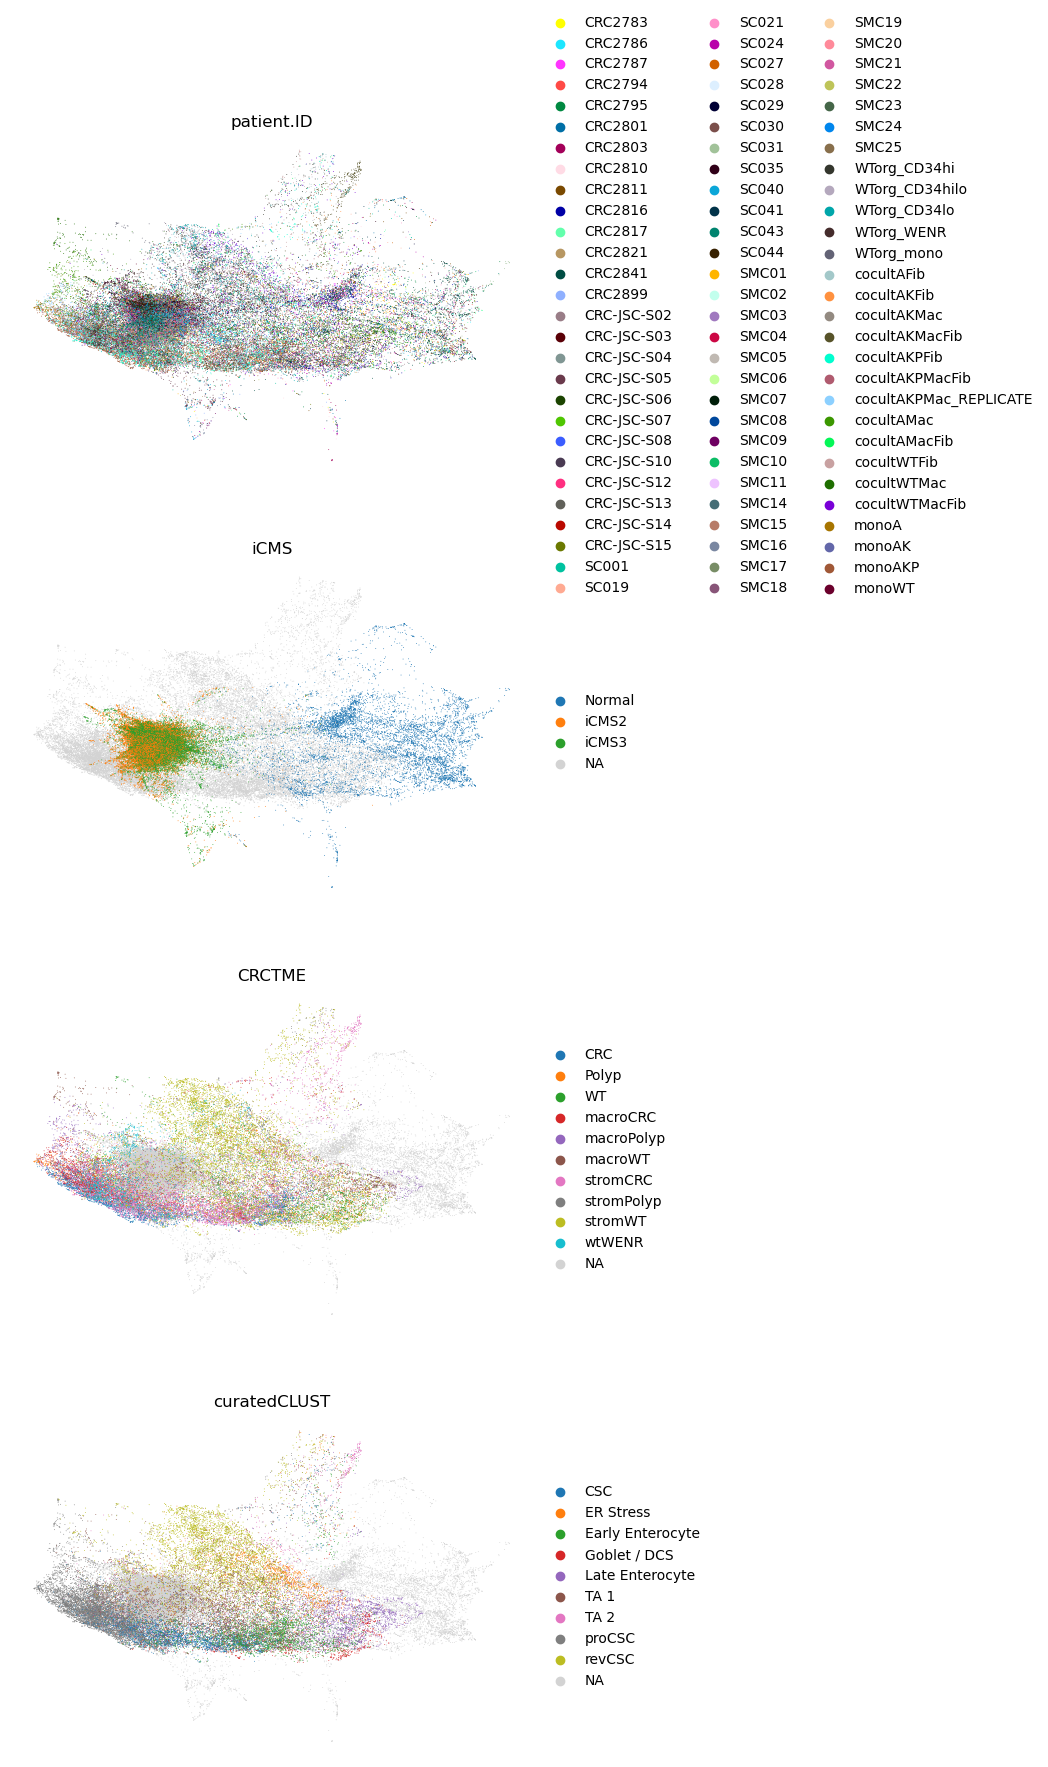

In [16]:
mouseData.obs["patient.ID"] = mouseData.obs["sample.ID"]

vae_q = scvi.model.SCVI.load_query_data(
    mouseData,
    "humanREF_model/", #path to reference
)
vae_q.train(max_epochs=200, plan_kwargs=dict(weight_decay=0.0))
mouseData.obsm["X_scVI"] = vae_q.get_latent_representation()
sc.pp.neighbors(mouseData, use_rep="X_scVI")
sc.tl.umap(mouseData, min_dist=0.3)
phate_data = phate_operator.fit_transform(mouseData.obsm["X_scVI"])
mouseData.obsm["X_phateINT"] = phate_data
sc.pl.embedding(mouseData, basis="X_phateINT", 
                color = ["patient.ID", "sample.ID","curatedCLUST","experiment"],
                ncols=2,
                frameon=False)

intData = mouseData.concatenate(humanData)
intData.obsm["X_scVI"] = vae_q.get_latent_representation(intData)
sc.pl.embedding(intData, basis="X_phateINT", 
                color = ["patient.ID","iCMS","CRCTME","curatedCLUST"],
                ncols=1,
                frameon=False)

Very smooth integration that most closely ressembles the Seurat rPCA implementation.

In [17]:
intData.write_h5ad("../OnRequest/epi_INT.h5ad", compression=True)

# Pluripotency score

CCAT

In [15]:
import pickle
import rpy2
import rpy2.situation

import rpy2.robjects as ro
from rpy2.robjects import pandas2ri


for row in rpy2.situation.iter_info(): # Print Rpy2 info
    print(row)

%load_ext rpy2.ipython

rpy2 version:
3.5.11
Python version:
3.9.16 | packaged by conda-forge | (main, Feb  1 2023, 21:39:03) 
[GCC 11.3.0]
Looking for R's HOME:
    Environment variable R_HOME: /var/home/ferran/miniconda3/envs/scvi-env/lib/R
    Calling `R RHOME`: /var/home/ferran/miniconda3/envs/scvi-env/lib/R
    Environment variable R_LIBS_USER: None
R's additions to LD_LIBRARY_PATH:

R version:
    In the PATH: R version 4.2.3 (2023-03-15) -- "Shortstop Beagle"
    Loading R library from rpy2: OK
Additional directories to load R packages from:
None
C extension compilation:
  include:
  ['/var/home/ferran/miniconda3/envs/scvi-env/lib/R/include']
  libraries:
  ['R', 'pcre2-8', 'lzma', 'bz2', 'z', 'rt', 'dl', 'm', 'iconv', 'icuuc', 'icui18n']
  library_dirs:
  ['/var/home/ferran/miniconda3/envs/scvi-env/lib', '/var/home/ferran/miniconda3/envs/scvi-env/lib/R/lib', '/var/home/ferran/miniconda3/envs/scvi-env/lib']
  extra_compile_args:
  ['-std=c99']
  extra_link_args:
  ['-Wl,--export-dynamic', '-fopenmp', '

In [6]:
# from biomart import BiomartServer

# mart = BiomartServer("http://www.ensembl.org/biomart").datasets["hsapiens_gene_ensembl"]
# # mart.show_attributes()
# # for i in mart.show_attributes_by_page():
# #     print(i)

# response = mart.search({
#     "attributes":[
#         "hgnc_symbol",
#         "entrezgene_id"
#         ]
#     })

# homology_dict = {}
# for row in response.iter_lines():
#     row = row.decode('utf-8').split("\t")
#     print(row[0],row[1])
#     homology_dict[row[0]] = row[1]



# with open("data/homology_dict.pkl", "wb") as f:
#     pickle.dump(homology_dict, f)

In [12]:
humanData.raw.var.index

Index(['AL645608.1', 'SAMD11', 'HES4', 'ISG15', 'AGRN', 'TNFRSF18', 'TNFRSF4',
       'C1QTNF12', 'MXRA8', 'ANKRD65',
       ...
       'COL6A2', 'FTCD', 'LSS', 'C21orf58', 'S100B', 'AC141272.1',
       'AC007325.2', 'AC004556.1', 'AC233755.2', 'AC233755.1'],
      dtype='object', length=6000)

In [13]:
with open("data/homology_dict.pkl", "rb") as f:
    homology_dict = pickle.load(f)
    
humanData.raw.var.index = humanData.raw.var.index.map(homology_dict)
count_matrix = pd.DataFrame(data=humanData.raw.X.toarray(), index=humanData.obs.index, columns=humanData.raw.var.index).T
count_matrix = count_matrix[~count_matrix.index.isna()]
count_matrix = count_matrix[~count_matrix.index.duplicated()]
count_matrix.to_hdf("../OnRequest/epi_iCMSh_counts.h5",key="count_matrix", mode="w")
del(humanData)

mouseData.var_names = mouseData.var_names.map(homology_dict)
count_matrix = pd.DataFrame(data=mouseData.X.toarray(), index=mouseData.obs.index, columns=mouseData.var_names).T
count_matrix = count_matrix[~count_matrix.index.isna()]
count_matrix = count_matrix[~count_matrix.index.duplicated()]
count_matrix.to_hdf("../OnRequest/epi_CRCTMEh_counts.h5",key="count_matrix", mode="w")
del(mouseData)

In [14]:
%%R

library(tidyverse)
library(SCENT)
library(rhdf5)

data(net17Jan16)
print(dim(net17Jan16.m))

print(help(CompCCAT))

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.2     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.2     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.1     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


R[write to console]: The legacy packages maptools, rgdal, and rgeos, underpinning this package
will retire shortly. Please refer to R-spatial evolution reports on
https://r-spatial.org/r/2023/05/15/evolution4.html for details.
This package is now running under evolution status 0 



[1] 11751 11751
File: /tmp/RtmpTRef03/Rtxt31423234800ff
CompCCAT                 package:SCENT                 R Documentation



Correlation of Connectome And Transcriptome



Description:



     This function leverages Pearson correlation between gene expresion

     level and gene connectome derived from PPI network to fastly

     estimate signaling entropy rate.



Usage:



     CompCCAT(exp.m, ppiA.m)

     

Arguments:



   exp.m: A scRNA-Seq data matrix with rows labeling genes and columns

          labeling single cells and with rownames annotated to a

          gene-identifier identical to that used in the ‘ppiA.m’

          argument. scRNA-Seq data matrix should have undergone prior

          QC to remove poor quality cells and each cell normalized by

          library size. If data has not been log-transformed, the

          function will log2-transform with a pseudocount of +1.



  ppiA.m: The adjacency matrix of a user-given PPI network with

          rownames 

In [15]:
%%R

hdf5_human = h5read("../OnRequest/epi_iCMSh_counts.h5","count_matrix")
hdf5_mouse = h5read("../OnRequest/epi_CRCTMEh_counts.h5","count_matrix")

# print(dim(hdf5_data$axis0))
# print(head(hdf5_data$axis0))
# # print(head(hdf5_data$block0_items))
# print(dim(hdf5_data$axis1))
# print(head(hdf5_data$axis1))
# print(dim(hdf5_data$block0_values))


count_human = data.frame(t(hdf5_human$block0_values), row.names=hdf5_human$axis1)
colnames(count_human) <- hdf5_human$axis0

count_mouse = data.frame(t(hdf5_mouse$block0_values), row.names=hdf5_mouse$axis1)
colnames(count_mouse) <- hdf5_mouse$axis0

# count_matrix <- count_matrix[!duplicated(count_matrix$`...1`),]
# count_matrix <- na.omit(count_matrix) %>% column_to_rownames(var="...1")

In [16]:
%%R -o ccat_human,ccat_mouse

ccat_human <- CompCCAT(exp.m=data.matrix(count_human), ppiA.m=net17Jan16.m)
ccat_mouse <- CompCCAT(exp.m=data.matrix(count_mouse), ppiA.m=net17Jan16.m)

In [17]:
humanData = sc.read_h5ad("../OnRequest/epi_iCMSh.h5ad")
mouseData = sc.read_h5ad("../OnRequest/epi_CRCTMEh.h5ad")

In [18]:
humanData.obs["CCAT"] = ccat_human
mouseData.obs["CCAT"] = ccat_mouse

In [47]:
intData.obs["CCAT"] = np.concatenate((ccat_mouse, ccat_human))

/var/home/ferran/miniconda3/envs/scvi-env/lib/python3.9/site-packages/scanpy/plotting/_utils.py:430: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[value_to_plot + '_colors'] = colors_list
/var/home/ferran/miniconda3/envs/scvi-env/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


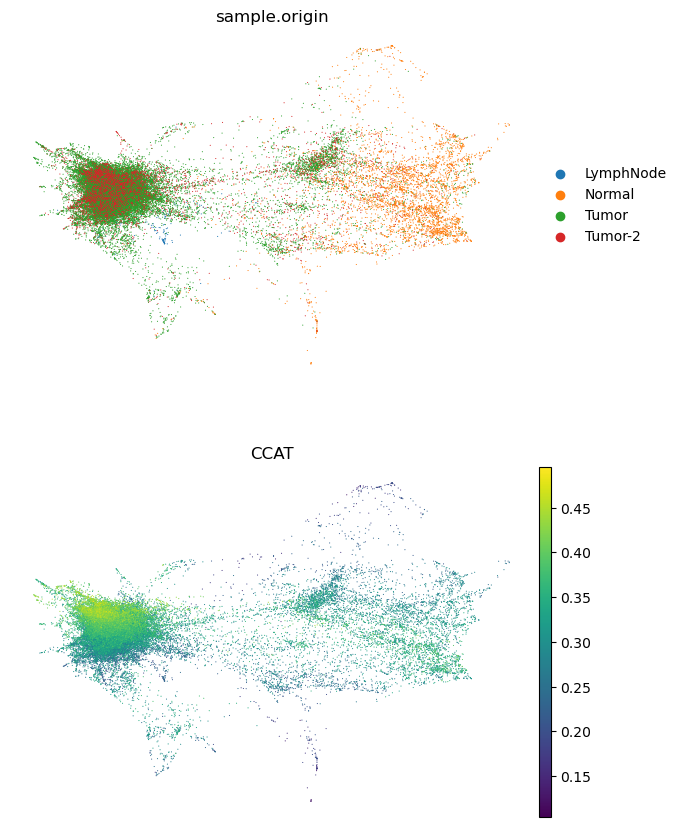

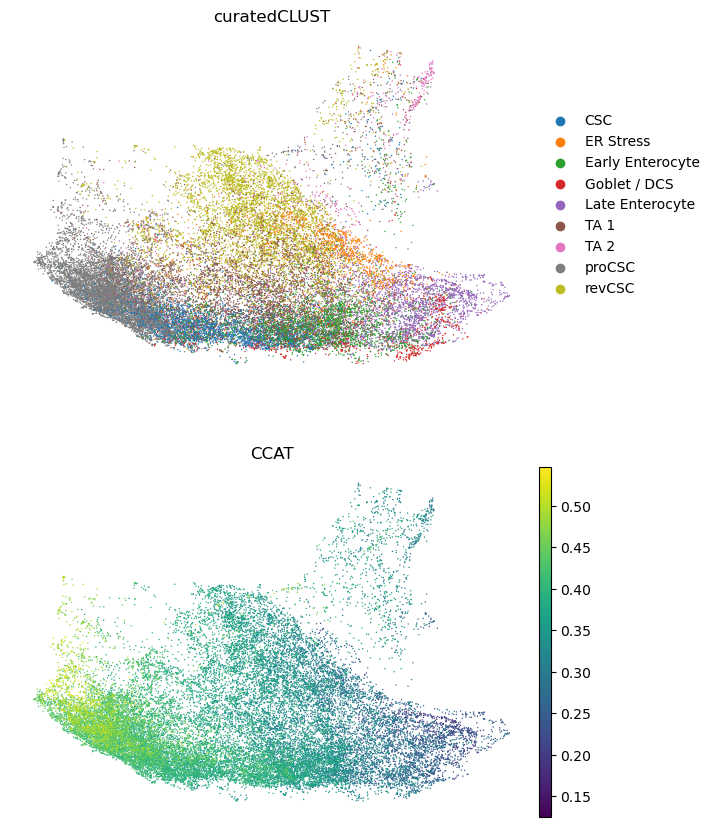

In [64]:
sc.pl.embedding(intData[intData.obs["batch"]=="1"], basis="X_phateINT", 
                color = ["sample.origin","CCAT"],
                ncols=1,
                frameon=False)
sc.pl.embedding(intData[intData.obs["batch"]=="0"], basis="X_phateINT", 
                color = ["curatedCLUST","CCAT"],
                ncols=1,
                frameon=False)

## Publication plots in ggplot

In [21]:
pd.concat([
    pd.DataFrame(intData[(intData.obs["batch"]=="1")].obsm["X_phateINT"], columns=["phate1","phate2"], index=intData[(intData.obs["batch"]=="1")].obs.index),
    intData[(intData.obs["batch"]=="1")].obs[["sample.origin","CCAT"]]], 
    axis=1).to_csv("data/dICMS.csv")

In [87]:
intData.obs["wtCLUST"] = intData.obs["curatedCLUST"].where(intData.obs["sample.ID"].isin(["monoWT", "WTorg_mono"]))
intData.obs["akCLUST"] = intData.obs["curatedCLUST"].where(intData.obs["sample.ID"]=="monoAK")
intData.obs["fibCLUST"] = intData.obs["curatedCLUST"].where(intData.obs["sample.ID"]=="cocultWTFib")
intData.obs["wenrCLUST"] = intData.obs["curatedCLUST"].where(intData.obs["sample.ID"]=="WTorg_WENR")

/var/home/ferran/miniconda3/envs/scvi-env/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


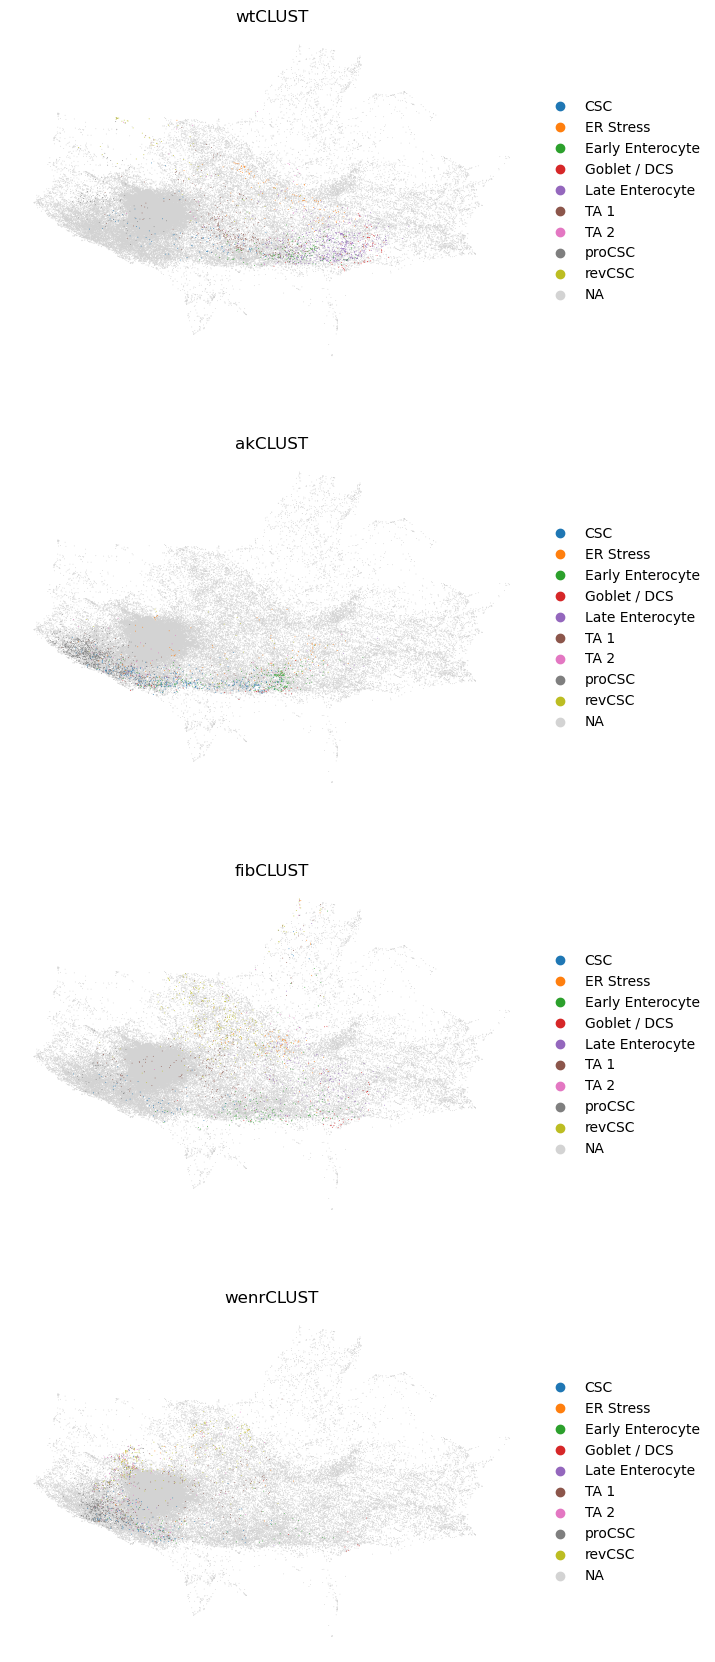

In [88]:
sc.pl.embedding(intData, basis="X_phateINT", 
                color = ["wtCLUST","akCLUST","fibCLUST","wenrCLUST"],
                ncols=1,
                frameon=False)

/var/home/ferran/miniconda3/envs/scvi-env/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


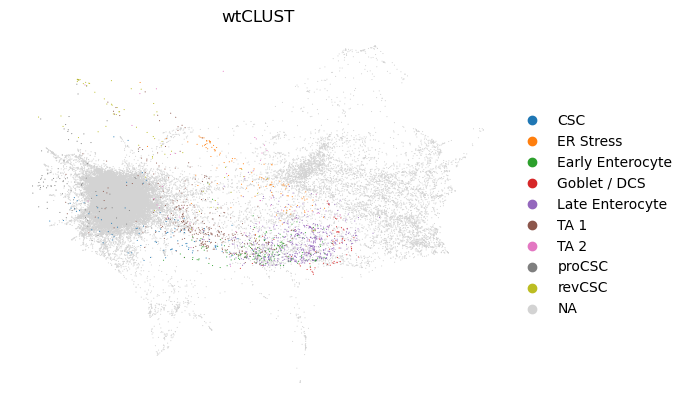

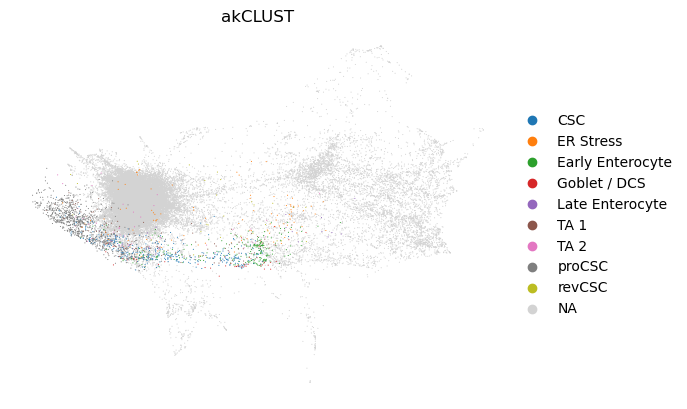

In [5]:
sc.pl.embedding(intData[(intData.obs["batch"]=="1")|(intData.obs["sample.ID"].isin(["monoWT", "WTorg_mono"]))], 
                basis="X_phateINT", 
                color = ["wtCLUST"],
                ncols=1,
                frameon=False)
sc.pl.embedding(intData[(intData.obs["batch"]=="1")|(intData.obs["sample.ID"]=="monoAK")], 
                basis="X_phateINT", 
                color = ["akCLUST"],
                ncols=1,
                frameon=False)

## CCAT dispersion as measure of plasticity

<Axes: xlabel='CRCTME', ylabel='CCAT'>

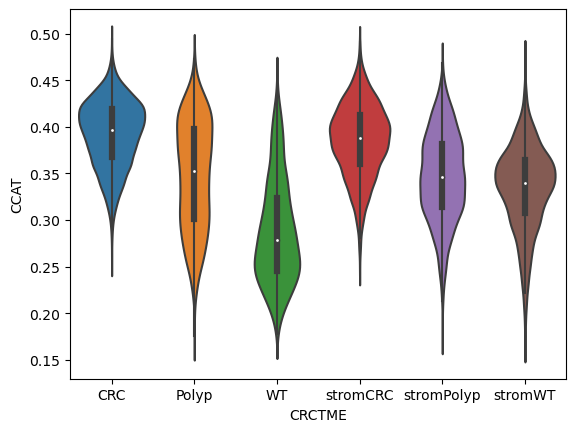

In [177]:
# sc.pl.violin(intData, keys="CCAT", 
#             groupby="CRCTME",
#             stripplot=False)
sns.violinplot(
    data=intData[(intData.obs["batch"]=="0")&(intData.obs["CRCTME"].isin(["WT","Polyp","CRC","stromWT","stromCRC","stromPolyp"]))].obs,
    x="CRCTME",y="CCAT")

<Axes: xlabel='experiment', ylabel='CCAT'>

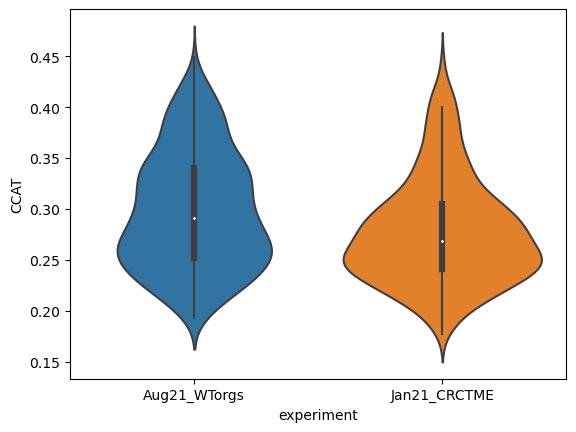

In [178]:
sns.violinplot(
    data=intData[(intData.obs["batch"]=="0")&(intData.obs["CRCTME"].isin(["WT"]))].obs,
    x="experiment",y="CCAT")

In [128]:
humanData = intData[(intData.obs["batch"]=="1")]

In [133]:
humanData.obs["sample.origin"] = humanData.obs["sample.origin"].astype("str")
humanData.obs["Sample"] = humanData.obs["sample.origin"].where(humanData.obs["sample.origin"].isin(["LymphNode","Normal"]), "Tumor")
humanData.obs[["sample.origin","Sample"]]

sample.origin Sample
count          49155  49155
unique             4      3
top            Tumor  Tumor
freq           35714  44458

In [134]:
std_humanCCAT = humanData.obs.groupby(["Sample","patient.ID"]).describe()["CCAT"].reset_index()
std_humanCCAT

Sample patient.ID   count      mean       std       min       25%  \
0    LymphNode    CRC2801   696.0  0.345583  0.035457  0.211374  0.325902   
1    LymphNode    CRC2817   298.0  0.259078  0.037852  0.164948  0.235070   
2    LymphNode    CRC2841    42.0  0.343980  0.040165  0.257093  0.319794   
3       Normal    CRC2783   162.0  0.304113  0.044450  0.194579  0.275152   
4       Normal    CRC2786    18.0  0.288217  0.033817  0.235768  0.257148   
..         ...        ...     ...       ...       ...       ...       ...   
98       Tumor      SMC21  1583.0  0.304849  0.041054  0.188899  0.275347   
99       Tumor      SMC22  1569.0  0.318107  0.043543  0.182848  0.287720   
100      Tumor      SMC23   246.0  0.314010  0.047974  0.197094  0.277509   
101      Tumor      SMC24   293.0  0.316784  0.044909  0.214348  0.281881   
102      Tumor      SMC25   397.0  0.311686  0.047733  0.194758  0.275680   

          50%       75%       max  
0    0.349415  0.369461  0.443563  
1    0.256956  0.283611  0.371834  
2    0.343715  0.377224  0.412641  
3    0.306589  0.338791  0.416653  
4    0.289147  0.313079  0.338731  
..        ...       ...       ...  
98   0.302073  0.333649  0.423693  
99   0.318814  0.350240  0.428558  
100  0.319947  0.348902  0.438995  
101  0.314878  0.348522  0.437882  
102  0.308490  0.347288  0.437459  

[103 rows x 10 columns]

In [135]:
std_humanCCAT["IQR"] = std_humanCCAT["75%"]-std_humanCCAT["25%"]
std_humanCCAT

Sample patient.ID   count      mean       std       min       25%  \
0    LymphNode    CRC2801   696.0  0.345583  0.035457  0.211374  0.325902   
1    LymphNode    CRC2817   298.0  0.259078  0.037852  0.164948  0.235070   
2    LymphNode    CRC2841    42.0  0.343980  0.040165  0.257093  0.319794   
3       Normal    CRC2783   162.0  0.304113  0.044450  0.194579  0.275152   
4       Normal    CRC2786    18.0  0.288217  0.033817  0.235768  0.257148   
..         ...        ...     ...       ...       ...       ...       ...   
98       Tumor      SMC21  1583.0  0.304849  0.041054  0.188899  0.275347   
99       Tumor      SMC22  1569.0  0.318107  0.043543  0.182848  0.287720   
100      Tumor      SMC23   246.0  0.314010  0.047974  0.197094  0.277509   
101      Tumor      SMC24   293.0  0.316784  0.044909  0.214348  0.281881   
102      Tumor      SMC25   397.0  0.311686  0.047733  0.194758  0.275680   

          50%       75%       max       IQR  
0    0.349415  0.369461  0.443563  0.043559  
1    0.256956  0.283611  0.371834  0.048541  
2    0.343715  0.377224  0.412641  0.057430  
3    0.306589  0.338791  0.416653  0.063639  
4    0.289147  0.313079  0.338731  0.055931  
..        ...       ...       ...       ...  
98   0.302073  0.333649  0.423693  0.058302  
99   0.318814  0.350240  0.428558  0.062520  
100  0.319947  0.348902  0.438995  0.071394  
101  0.314878  0.348522  0.437882  0.066641  
102  0.308490  0.347288  0.437459  0.071607  

[103 rows x 11 columns]

In [136]:
std_humanCCAT.groupby(["Sample"]).describe()[["mean","std","IQR"]]

mean                                                              \
          count      mean       std       min       25%       50%       75%   
Sample                                                                        
LymphNode   3.0  0.316214  0.049487  0.259078  0.301529  0.343980  0.344781   
Normal     37.0  0.292406  0.019385  0.248717  0.280682  0.286063  0.308827   
Tumor      63.0  0.325030  0.026204  0.271621  0.305779  0.325577  0.344903   

                      std            ...                       IQR            \
                max count      mean  ...       75%       max count      mean   
Sample                               ...                                       
LymphNode  0.345583   3.0  0.037824  ...  0.039008  0.040165   3.0  0.049843   
Normal     0.329083  37.0  0.048314  ...  0.058312  0.081699  37.0  0.067100   
Tumor      0.378632  63.0  0.047332  ...  0.051732  0.062688  63.0  0.064607   

                                                                       
                std       min       25%       50%       75%       max  
Sample                                                                 
LymphNode  0.007027  0.043559  0.046050  0.048541  0.052985  0.057430  
Normal     0.027012  0.008462  0.049063  0.063174  0.084431  0.130732  
Tumor      0.011780  0.028618  0.058228  0.063140  0.072582  0.093952  

[3 rows x 24 columns]

In [137]:
print("mean of the STD\n", std_humanCCAT.groupby(["Sample"]).mean()["std"])
print()
print("median of the STD\n", std_humanCCAT.groupby(["Sample"]).median()["std"])

mean of the STD
 Sample
LymphNode    0.037824
Normal       0.048314
Tumor        0.047332
Name: std, dtype: float64

median of the STD
 Sample
LymphNode    0.037852
Normal       0.045132
Tumor        0.046684
Name: std, dtype: float64


In [138]:
print("mean of the IQR\n", std_humanCCAT.groupby(["Sample"]).mean()["IQR"])
print()
print("median of the IQR\n", std_humanCCAT.groupby(["Sample"]).median()["IQR"])

mean of the IQR
 Sample
LymphNode    0.049843
Normal       0.067100
Tumor        0.064607
Name: IQR, dtype: float64

median of the IQR
 Sample
LymphNode    0.048541
Normal       0.063174
Tumor        0.063140
Name: IQR, dtype: float64


<Axes: xlabel='Sample', ylabel='std'>

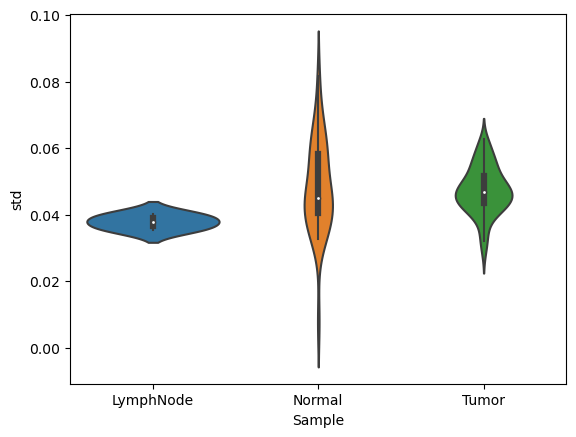

In [139]:
sns.violinplot(data=std_humanCCAT, x="Sample",y="std")

<Axes: xlabel='Sample', ylabel='IQR'>

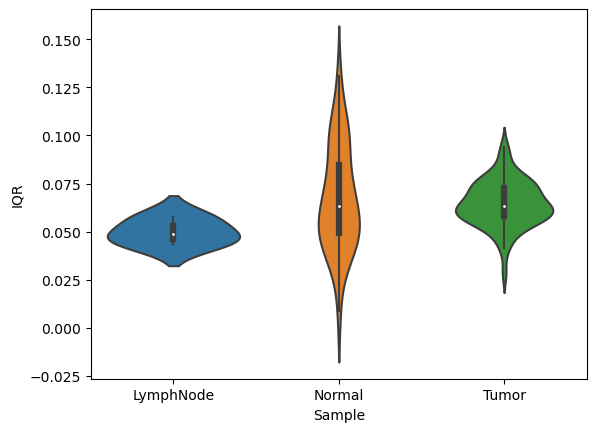

In [152]:
sns.violinplot(data=std_humanCCAT, x="Sample",y="IQR")

Plots can be made in R using ggstatsplot if need be

In [168]:
%%R -i std_humanCCAT,std_mouseCCAT

library(tidyverse)

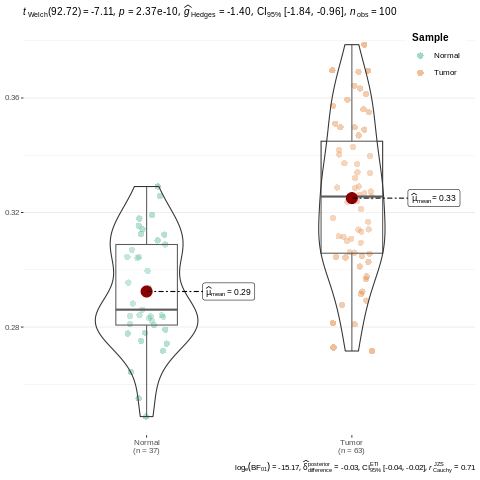

In [169]:
%%R

std_humanCCAT %>% filter(Sample!="LymphNode") %>% mutate(Sample = factor(Sample, levels=c("Normal","Tumor"))) %>%
ggstatsplot::ggbetweenstats(
                            x = Sample,
                            y = mean,
                            type="p",
                            plot.type = "boxviolin",
                            #point.args = c(size=0)
                            ) +
# scale_color_manual(values = c("#669966","#FF6666","#FF9900","#336699")) +
theme(
    legend.position = c(.98, 1),
                            legend.justification = c("right", "top"),
                            legend.box.just = "right",
                            legend.margin = margin(6, 6, 6, 6),
                            panel.grid.major.x = element_blank()
                                ) +
    labs(title = NULL, x=NULL, y=NULL, colour="Sample")



Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.


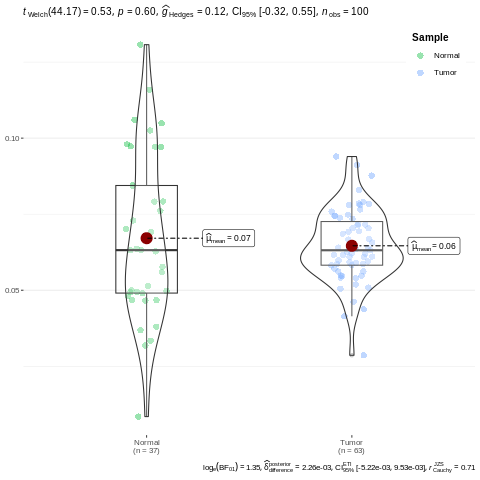

In [171]:
%%R

std_humanCCAT %>% filter(Sample!="LymphNode") %>% mutate(Sample = factor(Sample, levels=c("Normal","Tumor"))) %>%
ggstatsplot::ggbetweenstats(
                            x = Sample,
                            y = IQR,
                            type="p",
                            plot.type = "boxviolin",
                            #point.args = c(size=0)
                            ) +
scale_color_manual(values = c("#00BA38","#619CFF")) +
theme(
    legend.position = c(.98, 1),
                            legend.justification = c("right", "top"),
                            legend.box.just = "right",
                            legend.margin = margin(6, 6, 6, 6),
                            panel.grid.major.x = element_blank()
                                ) +
    labs(title = NULL, x=NULL, y=NULL, colour="Sample")



Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.


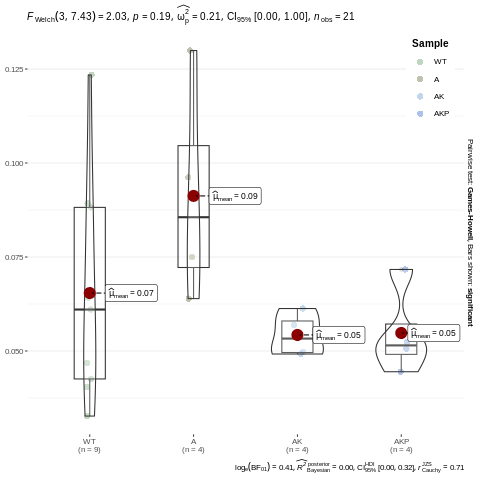

In [172]:
%%R

std_mouseCCAT %>% mutate(Genotype = factor(Genotype, levels=c("WT","A","AK","AKP"))) %>%
ggstatsplot::ggbetweenstats(
                            x = Genotype,
                            y = IQR,
                            type="p",
                            plot.type = "boxviolin",
                            #point.args = c(size=0)
                            ) +
scale_color_manual(values = palette_genotype) +
theme(
    legend.position = c(.98, 1),
                            legend.justification = c("right", "top"),
                            legend.box.just = "right",
                            legend.margin = margin(6, 6, 6, 6),
                            panel.grid.major.x = element_blank()
                                ) +
    labs(title = NULL, x=NULL, y=NULL, colour="Sample")

In [142]:
std_mouseCCAT = intData[(intData.obs["batch"]=="0")].obs.groupby(["Genotype","sample.ID"]).describe()["CCAT"].reset_index()
std_mouseCCAT

Genotype               sample.ID   count      mean       std       min  \
0         A              cocultAFib  1360.0  0.343034  0.044425  0.209043   
1         A              cocultAMac  1091.0  0.407748  0.086977  0.178719   
2         A           cocultAMacFib   410.0  0.357963  0.054952  0.177857   
3         A                   monoA  1701.0  0.348228  0.057813  0.175886   
4        AK             cocultAKFib  1478.0  0.368505  0.034102  0.248206   
5        AK             cocultAKMac  1104.0  0.451818  0.045905  0.240070   
6        AK          cocultAKMacFib  1837.0  0.390432  0.042560  0.244159   
7        AK                  monoAK  1860.0  0.397763  0.035111  0.263950   
8       AKP            cocultAKPFib  1828.0  0.384583  0.035837  0.258002   
9       AKP         cocultAKPMacFib   912.0  0.402573  0.035151  0.274437   
10      AKP  cocultAKPMac_REPLICATE  1017.0  0.459376  0.050770  0.224962   
11      AKP                 monoAKP  2293.0  0.388038  0.035640  0.253780   
12       WT            WTorg_CD34hi  2464.0  0.336235  0.033262  0.205148   
13       WT          WTorg_CD34hilo  1603.0  0.351621  0.034013  0.196076   
14       WT            WTorg_CD34lo  1365.0  0.350507  0.037638  0.192585   
15       WT              WTorg_WENR  1391.0  0.411015  0.027071  0.299393   
16       WT              WTorg_mono   732.0  0.298169  0.057649  0.193098   
17       WT             cocultWTFib  1139.0  0.307587  0.045815  0.162731   
18       WT             cocultWTMac  1340.0  0.283571  0.083218  0.124549   
19       WT          cocultWTMacFib  1550.0  0.319003  0.060326  0.169131   
20       WT                  monoWT   779.0  0.277822  0.052196  0.177298   

         25%       50%       75%       max  
0   0.312264  0.342716  0.376196  0.454318  
1   0.345350  0.440057  0.475263  0.537873  
2   0.322955  0.365670  0.397924  0.468753  
3   0.301547  0.352278  0.397742  0.473017  
4   0.344426  0.371369  0.394151  0.470342  
5   0.425197  0.460479  0.486496  0.535102  
6   0.365637  0.394574  0.422521  0.490310  
7   0.374616  0.402740  0.423813  0.494842  
8   0.360881  0.387963  0.411529  0.466126  
9   0.381010  0.403814  0.425499  0.494055  
10  0.426999  0.470543  0.498684  0.546930  
11  0.362345  0.391915  0.414683  0.478916  
12  0.316376  0.339570  0.358944  0.437812  
13  0.333615  0.354173  0.374063  0.449065  
14  0.328698  0.353082  0.375541  0.452009  
15  0.396769  0.413042  0.429461  0.501472  
16  0.251539  0.290830  0.339739  0.448930  
17  0.276874  0.307586  0.337906  0.447816  
18  0.216563  0.264069  0.339992  0.520068  
19  0.274457  0.321427  0.363795  0.477799  
20  0.240761  0.268801  0.304937  0.445732

In [143]:
std_mouseCCAT["IQR"] = std_mouseCCAT["75%"]-std_mouseCCAT["25%"]
std_mouseCCAT

Genotype               sample.ID   count      mean       std       min  \
0         A              cocultAFib  1360.0  0.343034  0.044425  0.209043   
1         A              cocultAMac  1091.0  0.407748  0.086977  0.178719   
2         A           cocultAMacFib   410.0  0.357963  0.054952  0.177857   
3         A                   monoA  1701.0  0.348228  0.057813  0.175886   
4        AK             cocultAKFib  1478.0  0.368505  0.034102  0.248206   
5        AK             cocultAKMac  1104.0  0.451818  0.045905  0.240070   
6        AK          cocultAKMacFib  1837.0  0.390432  0.042560  0.244159   
7        AK                  monoAK  1860.0  0.397763  0.035111  0.263950   
8       AKP            cocultAKPFib  1828.0  0.384583  0.035837  0.258002   
9       AKP         cocultAKPMacFib   912.0  0.402573  0.035151  0.274437   
10      AKP  cocultAKPMac_REPLICATE  1017.0  0.459376  0.050770  0.224962   
11      AKP                 monoAKP  2293.0  0.388038  0.035640  0.253780   
12       WT            WTorg_CD34hi  2464.0  0.336235  0.033262  0.205148   
13       WT          WTorg_CD34hilo  1603.0  0.351621  0.034013  0.196076   
14       WT            WTorg_CD34lo  1365.0  0.350507  0.037638  0.192585   
15       WT              WTorg_WENR  1391.0  0.411015  0.027071  0.299393   
16       WT              WTorg_mono   732.0  0.298169  0.057649  0.193098   
17       WT             cocultWTFib  1139.0  0.307587  0.045815  0.162731   
18       WT             cocultWTMac  1340.0  0.283571  0.083218  0.124549   
19       WT          cocultWTMacFib  1550.0  0.319003  0.060326  0.169131   
20       WT                  monoWT   779.0  0.277822  0.052196  0.177298   

         25%       50%       75%       max       IQR  
0   0.312264  0.342716  0.376196  0.454318  0.063931  
1   0.345350  0.440057  0.475263  0.537873  0.129913  
2   0.322955  0.365670  0.397924  0.468753  0.074968  
3   0.301547  0.352278  0.397742  0.473017  0.096195  
4   0.344426  0.371369  0.394151  0.470342  0.049725  
5   0.425197  0.460479  0.486496  0.535102  0.061299  
6   0.365637  0.394574  0.422521  0.490310  0.056884  
7   0.374616  0.402740  0.423813  0.494842  0.049197  
8   0.360881  0.387963  0.411529  0.466126  0.050647  
9   0.381010  0.403814  0.425499  0.494055  0.044489  
10  0.426999  0.470543  0.498684  0.546930  0.071686  
11  0.362345  0.391915  0.414683  0.478916  0.052339  
12  0.316376  0.339570  0.358944  0.437812  0.042569  
13  0.333615  0.354173  0.374063  0.449065  0.040448  
14  0.328698  0.353082  0.375541  0.452009  0.046844  
15  0.396769  0.413042  0.429461  0.501472  0.032691  
16  0.251539  0.290830  0.339739  0.448930  0.088200  
17  0.276874  0.307586  0.337906  0.447816  0.061032  
18  0.216563  0.264069  0.339992  0.520068  0.123430  
19  0.274457  0.321427  0.363795  0.477799  0.089338  
20  0.240761  0.268801  0.304937  0.445732  0.064177

In [145]:
print("mean of the STD\n", std_mouseCCAT.groupby(["Genotype"]).mean()["std"])
print()
print("median of the STD\n", std_mouseCCAT.groupby(["Genotype"]).median()["std"])

mean of the STD
 Genotype
A      0.061042
AK     0.039420
AKP    0.039350
WT     0.047910
Name: std, dtype: float64

median of the STD
 Genotype
A      0.056382
AK     0.038835
AKP    0.035739
WT     0.045815
Name: std, dtype: float64


In [145]:
print("mean of the IQR\n", std_mouseCCAT.groupby(["Genotype"]).mean()["IQR"])
print()
print("median of the IQR\n", std_mouseCCAT.groupby(["Genotype"]).median()["IQR"])

mean of the IQR
 Genotype
A      0.091252
AK     0.054276
AKP    0.054790
WT     0.065414
Name: IQR, dtype: float64

median of the IQR
 Genotype
A      0.085582
AK     0.053304
AKP    0.051493
WT     0.061032
Name: IQR, dtype: float64


<Axes: xlabel='Genotype', ylabel='std'>

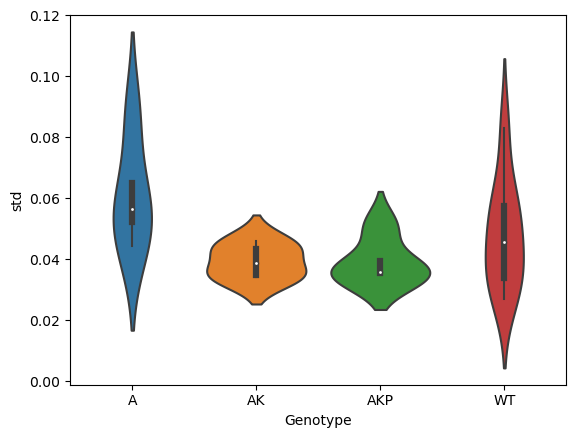

In [146]:
sns.violinplot(data=std_mouseCCAT, x="Genotype",y="std")

<Axes: xlabel='Genotype', ylabel='IQR'>

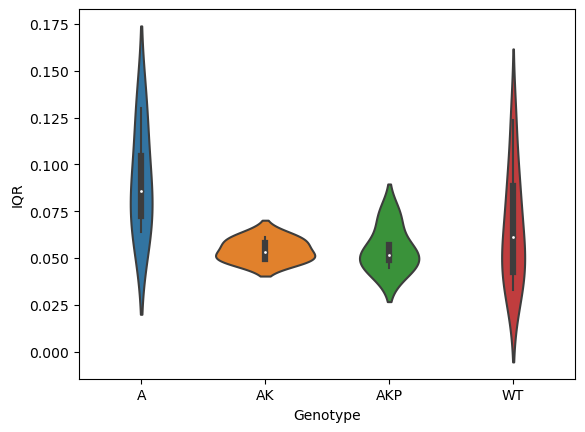

In [146]:
sns.violinplot(data=std_mouseCCAT, x="Genotype",y="IQR")

<Axes: xlabel='Genotype', ylabel='mean'>

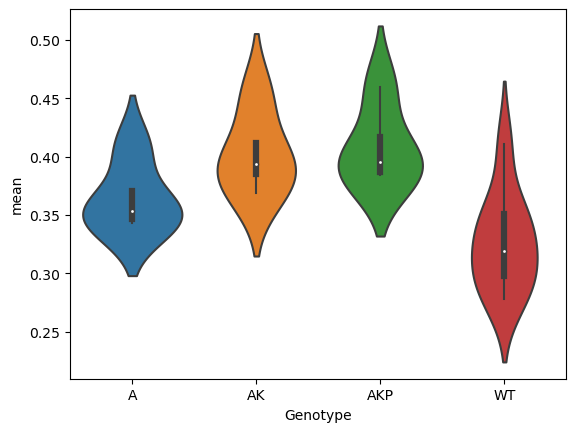

In [147]:
sns.violinplot(data=std_mouseCCAT, x="Genotype",y="mean")

# Signatures

Test our signatures on their data (visually inspecting the embedding)

In [3]:
intData = sc.read_h5ad("data/epi_INT.h5ad")

In [61]:
# Receptor expression (cellchat CRCTME results)
receptor_list = [
    'FZD5', 'LRP6','NRP1', 'PLXNA1', 'ACVR1', 'TGFBR1', 'TGFBR2', 'ACVR1B', 
    'ITGA6', 'ITGB4', 'IGF1R', 'ERBB2', 'ERBB3', 'EGFR', 'ERBB2', 'CD44', 
    'ITGAV', 'ITGB1', 'ITGB6', 'SDC1', 'SDC4', 'NCL', 'TNFRSF12A', 'MET', 
    'SORT1', 'BMPR1A', 'BMPR2', 'ACVR2A'
]

In [62]:
stem_signatures = pd.read_csv("data/QinCardoso_DEstem.csv")
stem_signatures

GENE CLUSTER
0     Pla2g2a     CSC
1        Gpx2     CSC
2        Agr2     CSC
3        Oit1     CSC
4        Rgcc     CSC
..        ...     ...
67       Ctse  revCSC
68       Ctsl  revCSC
69       Tpm1  revCSC
70  Tnfrsf12a  revCSC
71       Ass1  revCSC

[72 rows x 2 columns]

In [63]:
from biomart import BiomartServer

mart = BiomartServer("http://www.ensembl.org/biomart").datasets["mmusculus_gene_ensembl"]
# mart.show_attributes()
# for i in mart.show_attributes_by_page():
#     print(i)

response = mart.search({
    "filters": {
        "mgi_symbol": stem_signatures["GENE"].to_list()
    },
    "attributes":[
        "external_gene_name",
        "hsapiens_homolog_associated_gene_name"
        ]
    })

homology_dict = {}
for row in response.iter_lines():
    row = row.decode('utf-8').split("\t")
    homology_dict[row[0]] = row[1]

homology_dict

stem_signatures["hGENE"] = stem_signatures["GENE"].map(homology_dict)

In [64]:
stem_signatures = stem_signatures.replace("", np.nan).dropna()
stem_signatures.groupby("CLUSTER").count()

GENE  hGENE
CLUSTER             
CSC        21     21
proCSC     23     23
revCSC     19     19

In [65]:
sign_icms2 = pd.read_csv("../data/signatures/JOANITOetal22_iCMS.csv")["iCMS2_Up"].dropna()
sign_icms3 = pd.read_csv("../data/signatures/JOANITOetal22_iCMS.csv")["iCMS3_Up"].dropna()
sign_mapk = pd.read_csv("../data/signatures/JOANITOetal22_mapkPath.csv")["GO_MAPK_ACT"].dropna()
sign_pi3k = pd.read_csv("../data/signatures/JOANITOetal22_mapkPath.csv")["GO_BP_PI3K_ACT"].dropna()
sign_tgfb = pd.read_csv("../data/signatures/JOANITOetal22_tgfbPath.csv")["KEGG_TGFB"].dropna()
sign_mycA = pd.read_csv("../data/signatures/JOANITOetal22_wntPath.csv")["Zeller_MYC_TARGETS"].dropna()
sign_mycB = pd.read_csv("../data/signatures/JOANITOetal22_wntPath.csv")["CP_MYC_TARGETS"].dropna()

sign_wntHAN20 = pd.Series(["AXIN2", "APCDD1", "NKD1", "TNFRSF19", "SMOC2", "CD44", "WNT6"])
sign_yapALVAREZ22 = pd.Series(["Anxa1", "Ccn1", "Ccn2", "Fjx1", "Axl", "Ereg", "Wwc2"]).str.upper()
sign_yapHAN20 = pd.Series(["Ankrd1", "Ccn1", "Ccn2", "Axl", "Msln", "Plaur"]).str.upper()

### UCELL

In [67]:
import rpy2
import rpy2.situation

import rpy2.robjects as ro
from rpy2.robjects import pandas2ri


for row in rpy2.situation.iter_info(): # Print Rpy2 info
    print(row)

%load_ext rpy2.ipython

rpy2 version:
3.5.11
Python version:
3.9.16 | packaged by conda-forge | (main, Feb  1 2023, 21:39:03) 
[GCC 11.3.0]
Looking for R's HOME:
    Environment variable R_HOME: /var/home/ferran/miniconda3/envs/scvi-env/lib/R
    Calling `R RHOME`: /var/home/ferran/miniconda3/envs/scvi-env/lib/R
    Environment variable R_LIBS_USER: None
R's additions to LD_LIBRARY_PATH:

R version:
    In the PATH: R version 4.2.3 (2023-03-15) -- "Shortstop Beagle"
    Loading R library from rpy2: OK
Additional directories to load R packages from:
None
C extension compilation:
  include:
  ['/var/home/ferran/miniconda3/envs/scvi-env/lib/R/include']
  libraries:
  ['R', 'pcre2-8', 'lzma', 'bz2', 'z', 'rt', 'dl', 'm', 'iconv', 'icuuc', 'icui18n']
  library_dirs:
  ['/var/home/ferran/miniconda3/envs/scvi-env/lib', '/var/home/ferran/miniconda3/envs/scvi-env/lib/R/lib', '/var/home/ferran/miniconda3/envs/scvi-env/lib']
  extra_compile_args:
  ['-std=c99']
  extra_link_args:
  ['-Wl,--export-dynamic', '-fopenmp', '

In [68]:
count_matrix = pd.DataFrame(data=intData.X.toarray(), index=intData.obs.index, columns=intData.var_names).T
count_matrix

AAACGAAGTACTCAAC-1_1-0  AAACGCTGTCAACCAT-1_1-0  \
AL645608.1                0.000000                0.000000   
SAMD11                    0.000000                0.000000   
HES4                      0.000000                0.000000   
ISG15                     0.468631                0.000000   
AGRN                      0.468631                0.527796   
...                            ...                     ...   
AC141272.1                0.000000                0.000000   
AC007325.2                0.000000                0.000000   
AC004556.1                0.000000                0.000000   
AC233755.2                0.000000                0.000000   
AC233755.1                0.000000                0.000000   

            AAACGCTTCCTTGACC-1_1-0  AAAGAACCACTGCATA-1_1-0  \
AL645608.1                     0.0                0.000000   
SAMD11                         0.0                0.000000   
HES4                           0.0                0.000000   
ISG15                          0.0                0.000000   
AGRN                           0.0                1.358102   
...                            ...                     ...   
AC141272.1                     0.0                0.000000   
AC007325.2                     0.0                0.000000   
AC004556.1                     0.0                0.000000   
AC233755.2                     0.0                0.000000   
AC233755.1                     0.0                0.000000   

            AAAGGATAGGCATGCA-1_1-0  AAAGGGCCATGCAGCC-1_1-0  \
AL645608.1                0.000000                     0.0   
SAMD11                    0.000000                     0.0   
HES4                      0.000000                     0.0   
ISG15                     1.133615                     0.0   
AGRN                      0.000000                     0.0   
...                            ...                     ...   
AC141272.1                0.000000                     0.0   
AC007325.2                0.000000                     0.0   
AC004556.1                0.000000                     0.0   
AC233755.2                0.000000                     0.0   
AC233755.1                0.000000                     0.0   

            AAAGTCCCAGAGAATT-1_1-0  AAAGTGACACTTCATT-1_1-0  \
AL645608.1                0.000000                0.000000   
SAMD11                    0.000000                0.000000   
HES4                      0.000000                0.000000   
ISG15                     0.000000                0.000000   
AGRN                      0.971591                0.555677   
...                            ...                     ...   
AC141272.1                0.000000                0.000000   
AC007325.2                0.000000                0.000000   
AC004556.1                0.000000                0.000000   
AC233755.2                0.000000                0.000000   
AC233755.1                0.000000                0.000000   

            AAAGTGAGTGATAGAT-1_1-0  AACAACCGTACTGAGG-1_1-0  ...  \
AL645608.1                     0.0                0.000000  ...   
SAMD11                         0.0                0.000000  ...   
HES4                           0.0                0.000000  ...   
ISG15                          0.0                0.000000  ...   
AGRN                           0.0                0.478168  ...   
...                            ...                     ...  ...   
AC141272.1                     0.0                0.000000  ...   
AC007325.2                     0.0                0.000000  ...   
AC004556.1                     0.0                0.000000  ...   
AC233755.2                     0.0                0.000000  ...   
AC233755.1                     0.0                0.000000  ...   

            KUL5_EXT129_ATTGGTGCATCGTCGG-1-1  \
AL645608.1                               0.0   
SAMD11                                   0.0   
HES4                                     0.0   
ISG15                              

In [69]:
count_matrix.to_hdf("../OnRequest/epi_INT_counts.h5",key="count_matrix", mode="w")

In [70]:
%%R
library(tidyverse)
library(UCell)
library(rhdf5)

help(ScoreSignatures_UCell)

File: /tmp/RtmpPH7uRi/Rtxt524552aa5177a
ScoreSignatures_UCell          package:UCell           R Documentation



Calculate module enrichment scores from single-cell data



Description:



     Given a gene vs. cell matrix, calculates module/signature

     enrichment scores on single-cell level using Mann-Whitney U

     statistic. UCell scores are normalized U statistics (between 0 and

     1), and they are mathematically related to the Area under the ROC

     curve (see Mason and Graham) These scores only depend on the gene

     expression ranks of individual cell, and therefore they are robust

     across datasets regardless of dataset composition.



Usage:



     ScoreSignatures_UCell(

       matrix = NULL,

       features,

       precalc.ranks = NULL,

       maxRank = 1500,

       w_neg = 1,

       name = "_UCell",

       assay = "counts",

       chunk.size = 1000,

       BPPARAM = NULL,

       ncores = 1,

       ties.method = "average",

       force.gc = FALSE

In [71]:
%%R

hdf5_data = h5read("../OnRequest/epi_INT_counts.h5","count_matrix")

print(dim(hdf5_data$axis0))
print(head(hdf5_data$block0_items))
print(dim(hdf5_data$axis1))
print(dim(hdf5_data$block0_values))

[1] 78409
[1] "AAACGAAGTACTCAAC-1_1-0" "AAACGCTGTCAACCAT-1_1-0" "AAACGCTTCCTTGACC-1_1-0"
[4] "AAAGAACCACTGCATA-1_1-0" "AAAGGATAGGCATGCA-1_1-0" "AAAGGGCCATGCAGCC-1_1-0"
[1] 6000
[1] 78409  6000


In [72]:
sign_icms2 = sign_icms2.tolist()
sign_icms3 =sign_icms3.tolist()
sign_mapk = sign_mapk.tolist()
sign_pi3k = sign_pi3k.tolist()
sign_tgfb = sign_tgfb.tolist()
sign_mycA = sign_mycA.tolist()
sign_mycB = sign_mycB.tolist()
sign_wntHAN20 = sign_wntHAN20.tolist()
sign_yapALVAREZ22 = sign_yapALVAREZ22.tolist()
sign_yapHAN20 = sign_yapHAN20.tolist()

sign_CSC = stem_signatures.loc[stem_signatures["CLUSTER"]=="CSC","hGENE"].to_list()
sign_proCSC = stem_signatures.loc[stem_signatures["CLUSTER"]=="proCSC","hGENE"].to_list()
sign_revCSC = stem_signatures.loc[stem_signatures["CLUSTER"]=="revCSC","hGENE"].to_list()

receptor_list

['FZD5',
 'LRP6',
 'NRP1',
 'PLXNA1',
 'ACVR1',
 'TGFBR1',
 'TGFBR2',
 'ACVR1B',
 'ITGA6',
 'ITGB4',
 'IGF1R',
 'ERBB2',
 'ERBB3',
 'EGFR',
 'ERBB2',
 'CD44',
 'ITGAV',
 'ITGB1',
 'ITGB6',
 'SDC1',
 'SDC4',
 'NCL',
 'TNFRSF12A',
 'MET',
 'SORT1',
 'BMPR1A',
 'BMPR2',
 'ACVR2A']

In [73]:
%%R -i sign_icms2,sign_icms3,sign_mapk,sign_mycA,sign_mycB,sign_pi3k,sign_tgfb,sign_wntHAN20,sign_yapALVAREZ22,sign_yapHAN20,sign_CSC,sign_proCSC,sign_revCSC,receptor_list -o ucellscores

count_matrix = data.frame(hdf5_data$block0_values, row.names=hdf5_data$axis0)
colnames(count_matrix) <- hdf5_data$axis1


ucellscores = ScoreSignatures_UCell(
    matrix = t(count_matrix),
    features = list(
        sign_icms2 =sign_icms2 ,
        sign_icms3 =sign_icms3 ,
        sign_mapk =sign_mapk ,
        sign_mycA =sign_mycA ,
        sign_mycB =sign_mycB ,
        sign_pi3k = sign_pi3k,
        sign_tgfb =sign_tgfb ,
        sign_wntHAN20 =sign_wntHAN20 ,
        sign_yapALVAREZ22 = sign_yapALVAREZ22,
        sign_yapHAN20 =sign_yapHAN20,
        sign_CSC = sign_CSC,
        sign_proCSC = sign_proCSC,
        sign_revCSC = sign_revCSC,
        CCreceptors = receptor_list
    )
)

R[write to console]: Warning:
R[write to console]:  The following genes were not found and will be
                        imputed to exp=0:
* TP53RK,ACOT8,CDK5RAP1,STK4,RTF2,NFS1,RNF114,FUNDC2,ZDHHC9,STAU1,RNF113A,FMR1,UCKL1,PROSER1,GTF2F2,ASXL1,GID8,GTF2IRD1,NDRG3,STX16,SERINC3,TPD52L2,PIGU,VAPB,NCOA3,RALY,PHF20,DYNLRB1,FTL,KPNA3,NKAP,PQBP1,MRGBP,IFT52,SCAND1,XRN2,ARFRP1,RALGAPB,MPLKIP,ATP5F1E,OSBPL2,SYS1,SLC7A6,ERGIC3,PCIF1,RPN2,MCTS1,RBM39,BCAP31,TBRG4,ATP6V1H,MICU2,COX19,FNTA,SPATA13,LAMP2,DNAJC5,DARS,RP9,DIDO1,EIF3H,MRPS31,PET117,YTHDF1,SINHCAF,TRPC4AP,LYPLA1,SPRYD7,PCID2,PGRMC1,SLC52A2,UPF3A,EPB41L5,ZC3H13,RNF6,NCBP2,CHD6,PDPK1,HUS1,C1GALT1C1,UBAC2,EXOSC5,EDEM2,VBP1,NDFIP2,RPUSD1,CDK8,VMA21,CSNK2A2,NAE1,NIT2,COMMD6,ABRACL,UTP4,LAGE3,GPALPP1,MED30,MALSU1,PAN3,OGFR,ZFAND1,HSD17B10,MRPL13,SUCLA2,IMMP2L,NHLRC3,RPIA,AC004130.1,SLC35C2,ARMC1,TXLNG,NUPL2,BLCAP,CDC16,SMIM26,UBA2,COPS5,TXNDC9,AVL9,RBMX2,RIDA,HIBADH,IPO5,ARFGAP1,MED4,PEX16,CAPZA2,RPRD1B,ALKBH3,SUPT20H,TNFRSF10B,DNAJC10,TS

In [74]:
ucellscores_df = pd.DataFrame(data=ucellscores, index=intData.obs.index, 
    columns=["sign_icms2","sign_icms3","sign_mapk","sign_mycA","sign_mycB",
    "sign_pi3k","sign_tgfb","sign_wntHAN20","sign_yapALVAREZ22","sign_yapHAN20",
    "sign_CSC","sign_proCSC","sign_revCSC","CCreceptors"])
ucellscores_df

sign_icms2  sign_icms3  sign_mapk  \
AAACGAAGTACTCAAC-1_1-0              0.285673    0.260302   0.026364   
AAACGCTGTCAACCAT-1_1-0              0.261281    0.301518   0.026970   
AAACGCTTCCTTGACC-1_1-0              0.244092    0.223410   0.035682   
AAAGAACCACTGCATA-1_1-0              0.264218    0.183405   0.044015   
AAAGGATAGGCATGCA-1_1-0              0.243459    0.224905   0.000000   
...                                      ...         ...        ...   
KUL5_EXT129_CTGTGCTTCGCTTGTC-1-1    0.257597    0.103059   0.037894   
KUL5_EXT129_GAAATGAGTTCCTCCA-1-1    0.307590    0.127914   0.020303   
KUL5_EXT129_GATCGCGTCTGCTGTC-1-1    0.266477    0.123410   0.000000   
KUL5_EXT129_GGAACTTCAGGAATGC-1-1    0.297819    0.145437   0.039091   
KUL5_EXT129_TCACAAGGTTTGGGCC-1-1    0.259532    0.102045   0.000000   

                                  sign_mycA  sign_mycB  sign_pi3k  sign_tgfb  \
AAACGAAGTACTCAAC-1_1-0             0.132599   0.171348   0.075658   0.089640   
AAACGCTGTCAACCAT-1_1-0             0.101034   0.126926   0.074158   0.078806   
AAACGCTTCCTTGACC-1_1-0             0.070190   0.060956   0.085500   0.085353   
AAAGAACCACTGCATA-1_1-0             0.210204   0.145104   0.055193   0.070795   
AAAGGATAGGCATGCA-1_1-0             0.126408   0.114215   0.073211   0.078105   
...                                     ...        ...        ...        ...   
KUL5_EXT129_CTGTGCTTCGCTTGTC-1-1   0.134510   0.136148   0.077553   0.076508   
KUL5_EXT129_GAAATGAGTTCCTCCA-1-1   0.230721   0.255793   0.094184   0.096279   
KUL5_EXT129_GATCGCGTCTGCTGTC-1-1   0.182102   0.221800   0.087307   0.101403   
KUL5_EXT129_GGAACTTCAGGAATGC-1-1   0.194252   0.218911   0.080561   0.104678   
KUL5_EXT129_TCACAAGGTTTGGGCC-1-1   0.226497   0.185037   0.092360   0.083570   

                                  sign_wntHAN20  sign_yapALVAREZ22  \
AAACGAAGTACTCAAC-1_1-0                 0.084952           0.129238   
AAACGCTGTCAACCAT-1_1-0                 0.064762           0.107667   
AAACGCTTCCTTGACC-1_1-0                 0.092143           0.092143   
AAAGAACCACTGCATA-1_1-0                 0.000000           0.134429   
AAAGGATAGGCATGCA-1_1-0                 0.087048           0.000000   
...                                         ...                ...   
KUL5_EXT129_CTGTGCTTCGCTTGTC-1-1       0.099095           0.000000   
KUL5_EXT129_GAAATGAGTTCCTCCA-1-1       0.120619           0.000000   
KUL5_EXT129_GATCGCGTCTGCTGTC-1-1       0.112095           0.000000   
KUL5_EXT129_GGAACTTCAGGAATGC-1-1       0.152476           0.000000   
KUL5_EXT129_TCACAAGGTTTGGGCC-1-1       0.000000           0.000000   

                                  sign_yapHAN20  sign_CSC  sign_proCSC  \
AAACGAAGTACTCAAC-1_1-0                 0.295167  0.048635     0.170072   
AAACGCTGTCAACCAT-1_1-0                 0.166222  0.135619     0.113696   
AAACGCTTCCTTGACC-1_1-0                 0.167278  0.036714     0.101058   
AAAGAACCACTGCATA-1_1-0                 0.163889  0.130714     0.311681   
AAAGGATAGGCATGCA-1_1-0                 0.164389  0.000000     0.175101   
...                                         ...       ...          ...   
KUL5_EXT129_CTGTGCTTCGCTTGTC-1-1       0.000000  0.180413     0.117826   
KUL5_EXT129_GAAATGAGTTCCTCCA-1-1       0.000000  0.284794     0.511449   
KUL5_EXT129_GATCGCGTCTGCTGTC-1-1       0.130111  0.227730     0.264014   
KUL5_EXT129_GGAACTTCAGGAATGC-1-1       0.000000  0.235317     0.190159   
KUL5_EXT129_TCACAAGGTTTGGGCC-1-1       0.000000  0.259984     0.370609   

                                  sign_revCSC  CCreceptors  
AAACGAAGTACTCAAC-1_1-0               0.300158     0.141383  
AAACGCTGTCAACCAT-1_1-0               0.297070     0.064654  
AAACGCTTCCTTGACC-1_1-0               0.234333     0.111877  
AAAGAACCACTGCATA-1_1-0               0.327860     0.129951  
AAAGGATAGGCATGCA-1_1-0               0.210333     0.080123  
...                                       ...          ...  
KUL5_EXT129_CTGTGCTTCGCTTGTC-1-1     0.186684     0.109358  
KU

In [75]:
intData.obs = intData.obs.join(ucellscores_df)

Compare CCAT with signatures

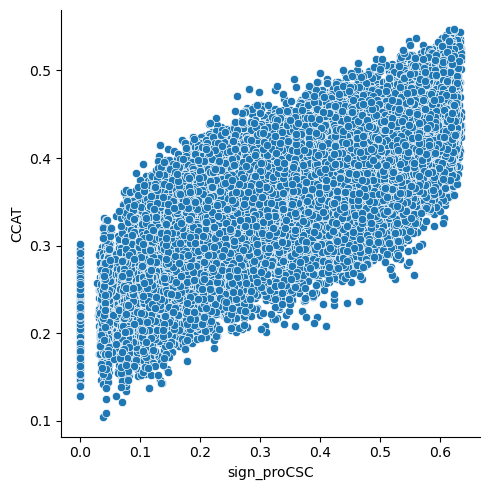

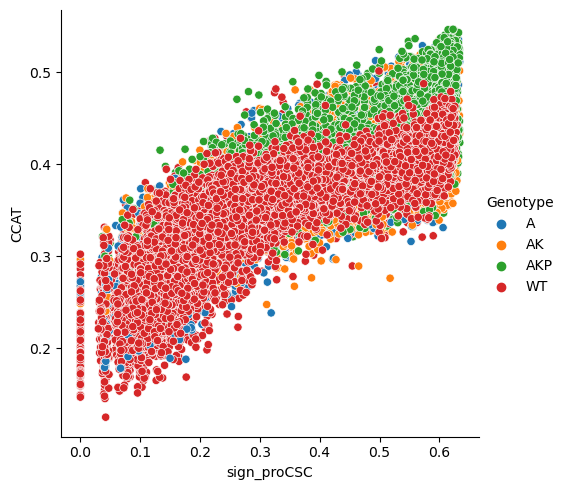

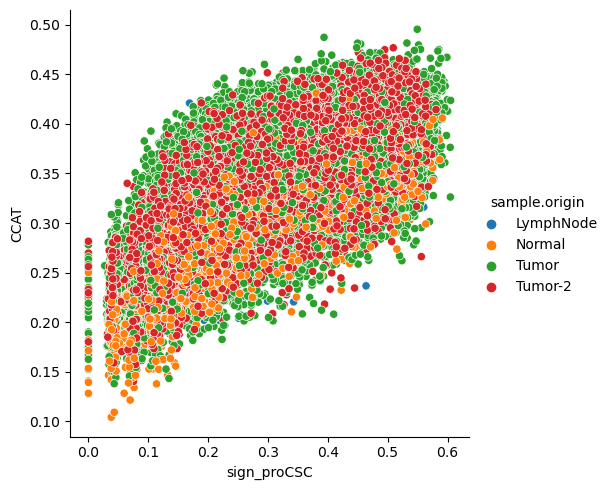

In [84]:
sns.relplot(intData.obs, x="sign_proCSC",y="CCAT")
sns.relplot(intData[(intData.obs["batch"]=="0")].obs, x="sign_proCSC",y="CCAT", hue="Genotype") #mouse
sns.relplot(intData[(intData.obs["batch"]=="1")].obs, x="sign_proCSC",y="CCAT",hue="sample.origin") #human

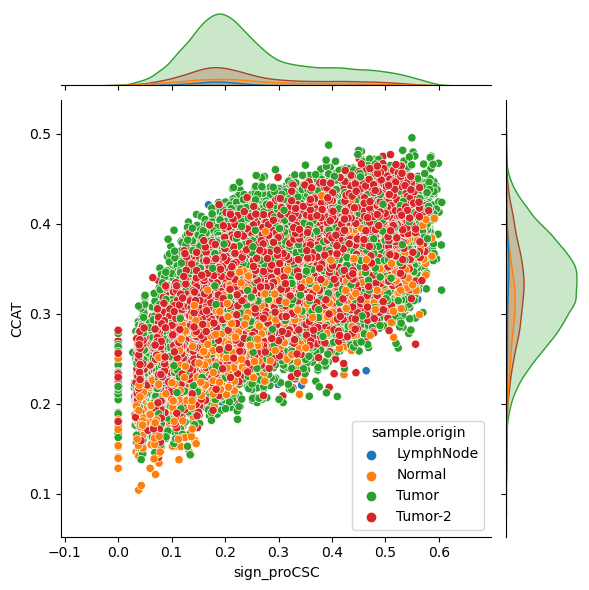

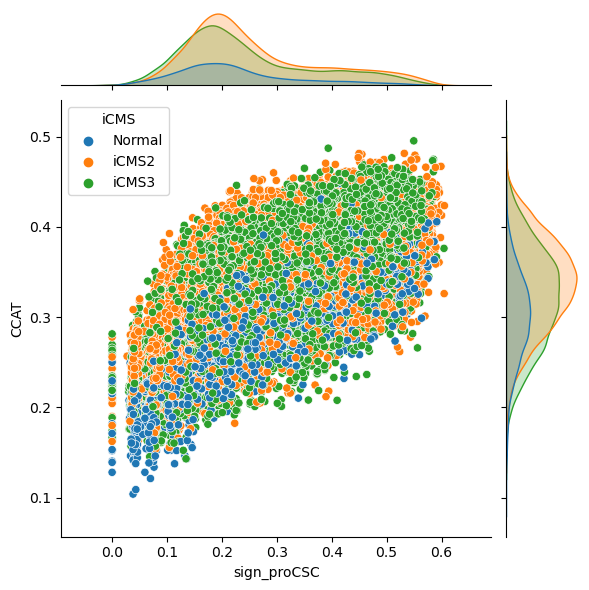

In [100]:
sns.jointplot(intData[(intData.obs["batch"]=="1")].obs, x="sign_proCSC",y="CCAT",hue="sample.origin") #human
sns.jointplot(intData[(intData.obs["batch"]=="1")].obs, x="sign_proCSC",y="CCAT",hue="iCMS") #human

Receptor score correlation with signatures

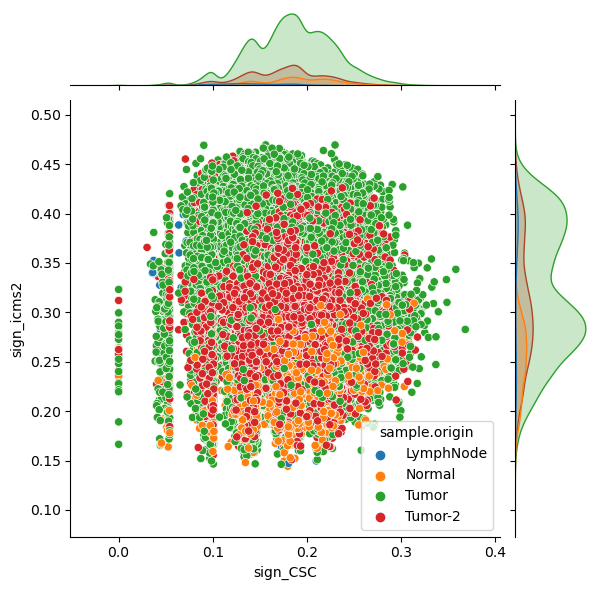

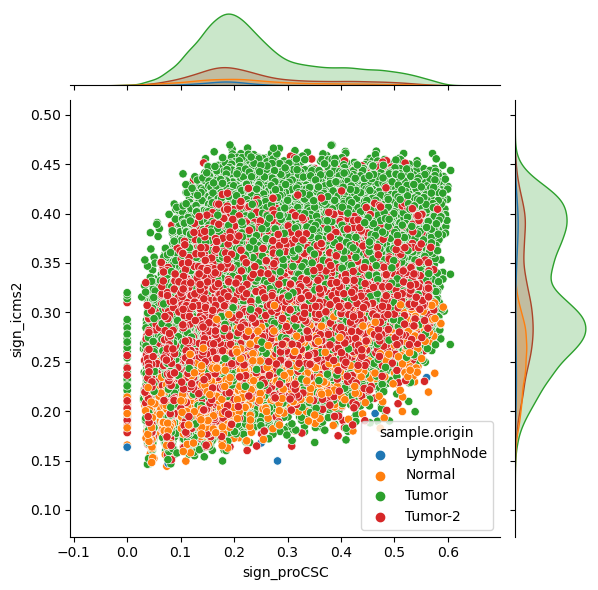

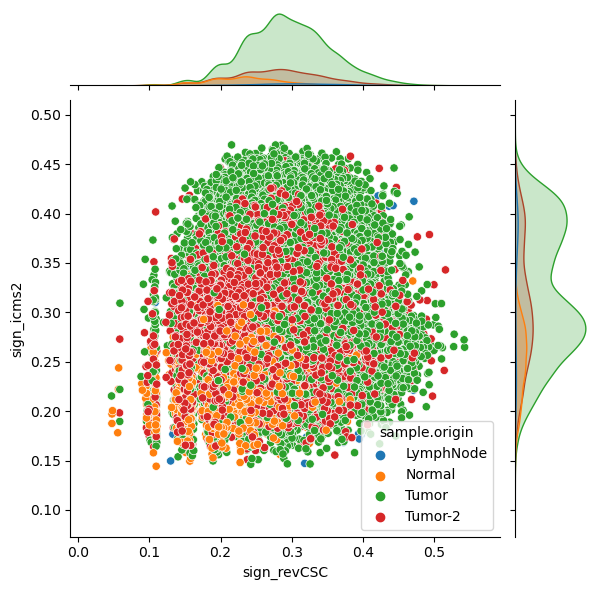

In [153]:
sns.jointplot(intData[(intData.obs["batch"]=="1")].obs, x="sign_CSC",y="sign_icms2", hue="sample.origin") #human
sns.jointplot(intData[(intData.obs["batch"]=="1")].obs, x="sign_proCSC",y="sign_icms2", hue="sample.origin") #human
sns.jointplot(intData[(intData.obs["batch"]=="1")].obs, x="sign_revCSC",y="sign_icms2", hue="sample.origin") #human

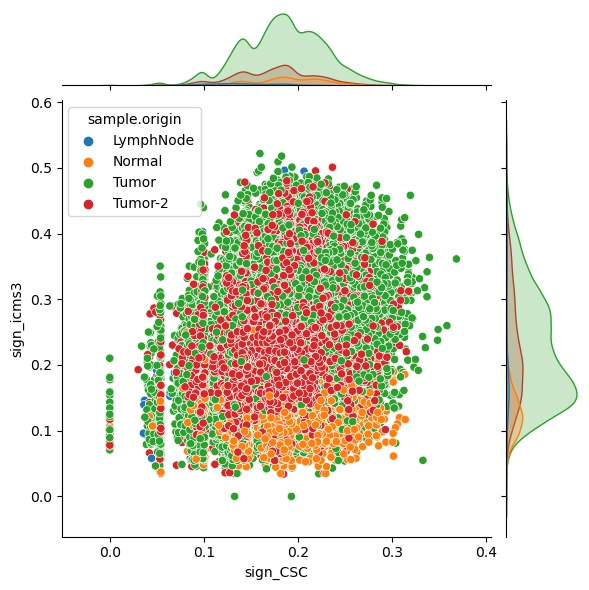

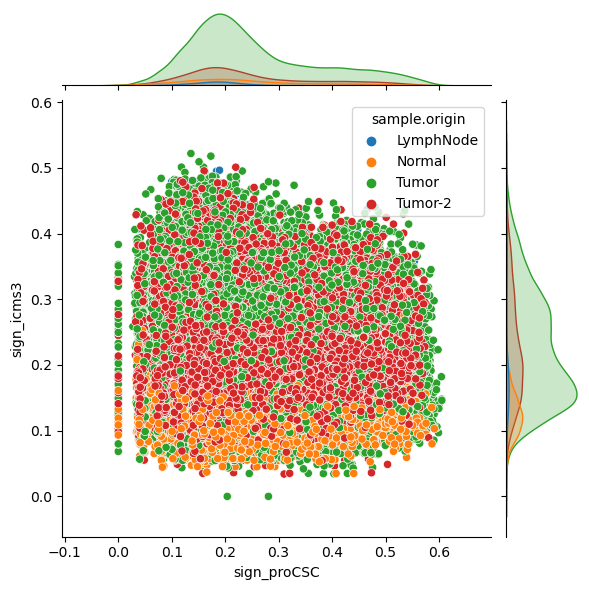

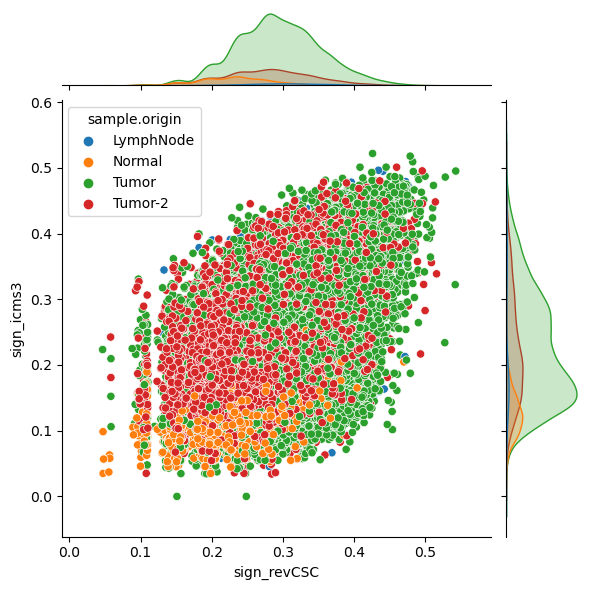

In [154]:
sns.jointplot(intData[(intData.obs["batch"]=="1")].obs, x="sign_CSC",y="sign_icms3", hue="sample.origin") #human
sns.jointplot(intData[(intData.obs["batch"]=="1")].obs, x="sign_proCSC",y="sign_icms3", hue="sample.origin") #human
sns.jointplot(intData[(intData.obs["batch"]=="1")].obs, x="sign_revCSC",y="sign_icms3", hue="sample.origin") #human

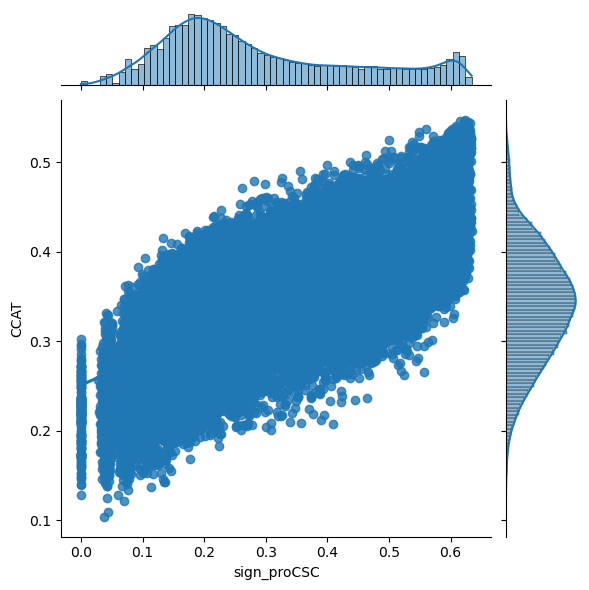

In [5]:
sns.jointplot(data=intData.obs, x="sign_proCSC",y="CCAT", kind="reg")

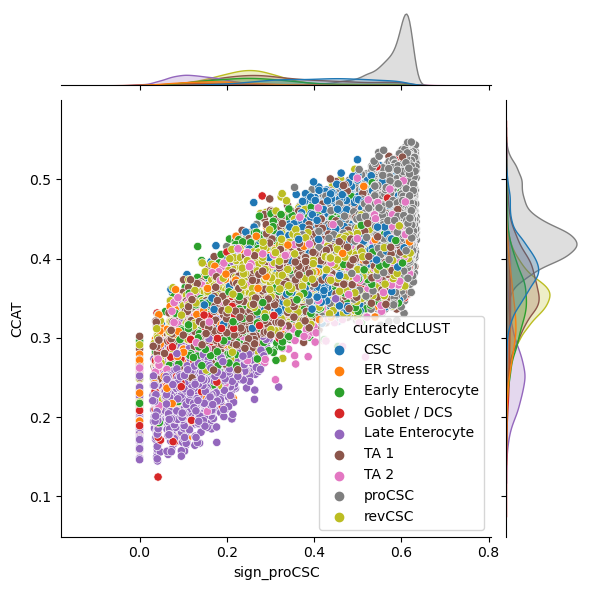

In [10]:
sns.jointplot(data=intData[(intData.obs["batch"]=="0")].obs, x="sign_proCSC",y="CCAT", hue="curatedCLUST")

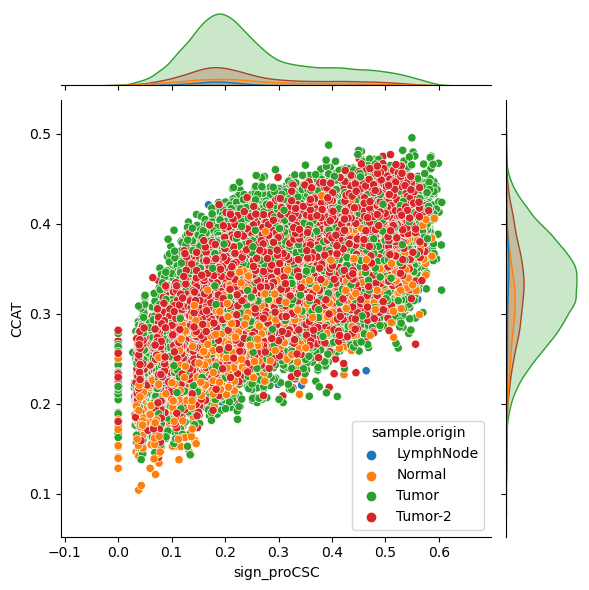

In [9]:
sns.jointplot(data=intData[(intData.obs["batch"]=="1")].obs, x="sign_proCSC",y="CCAT", hue="sample.origin")

Figure panels were generated with ggplot2 in R

In [3]:
import pickle
import rpy2
import rpy2.situation

import rpy2.robjects as ro
from rpy2.robjects import pandas2ri


for row in rpy2.situation.iter_info(): # Print Rpy2 info
    print(row)

%load_ext rpy2.ipython

rpy2 version:
3.5.11
Python version:
3.9.16 | packaged by conda-forge | (main, Feb  1 2023, 21:39:03) 
[GCC 11.3.0]
Looking for R's HOME:
    Environment variable R_HOME: /var/home/ferran/miniconda3/envs/scvi-env/lib/R
    Calling `R RHOME`: /var/home/ferran/miniconda3/envs/scvi-env/lib/R
    Environment variable R_LIBS_USER: None
R's additions to LD_LIBRARY_PATH:

R version:
    In the PATH: R version 4.2.3 (2023-03-15) -- "Shortstop Beagle"
    Loading R library from rpy2: OK
Additional directories to load R packages from:
None
C extension compilation:
  include:
  ['/var/home/ferran/miniconda3/envs/scvi-env/lib/R/include']
  libraries:
  ['R', 'pcre2-8', 'lzma', 'bz2', 'z', 'rt', 'dl', 'm', 'iconv', 'icuuc', 'icui18n']
  library_dirs:
  ['/var/home/ferran/miniconda3/envs/scvi-env/lib', '/var/home/ferran/miniconda3/envs/scvi-env/lib/R/lib', '/var/home/ferran/miniconda3/envs/scvi-env/lib']
  extra_compile_args:
  ['-std=c99']
  extra_link_args:
  ['-Wl,--export-dynamic', '-fopenmp', '

In [4]:
metadata = intData.obs

In [5]:
%%R -i metadata

class(metadata)

[1] "data.frame"


In [8]:
%%R
library(tidyverse)
library(ggExtra)
library(ggpubr)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.2     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.2     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.1     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


In [9]:
%%R

metadata <- metadata %>% mutate(Sample = case_when(
    sample.origin %in% c("Tumor","Tumor-2") ~ "Tumour",
    TRUE ~ sample.origin
))

In [89]:
%%R

palette_genotype <- c(
                    "WT"="#669966", 
                    "A"="#666633",
                    "AK"="#6699CC", 
                    "AKP"="#3366CC"
                    )

p <- ggplot(
    filter(.data=metadata, batch==0), 
    aes(x=sign_proCSC, y=CCAT, colour=Genotype)) +
    geom_point(aes(shape=".", alpha=0.6)) +
    scale_colour_manual(values=palette_genotype) +
    geom_smooth(inherit.aes = FALSE, aes(x=sign_proCSC, y=CCAT)) +
    stat_cor(inherit.aes = FALSE, aes(x=sign_proCSC, y=CCAT), method = "pearson", label.x = 0.02, label.y = 0.5) +
    egg::theme_article() +
    theme(
        legend.position = c(1, 0.4),
        legend.justification = c("right", "top"),
        legend.box.just = "right",
        legend.margin = margin(6, 6, 6, 6),
        axis.text = element_blank(),
        axis.ticks=element_blank(),
        panel.border = element_blank() #No boxes
        ) +
    guides(alpha = "none", shape="none") +
    labs(title = NULL, x="proCSC signature", y="CCAT", 
        color="Genotype")
# marginal density
p2 <- ggMarginal(
    p,
    type = 'density',
    margins = 'both',
    size = 12,
    groupFill = TRUE,
    groupColour = TRUE)

p2


`geom_smooth()` using method = 'gam' and formula = 'y ~ s(x, bs = "cs")'


`geom_smooth()` using method = 'gam' and formula = 'y ~ s(x, bs = "cs")'


In [182]:
%%R


palette_clust <- c(
                "revCSC" = "#CC0000",#CC0000
                "proCSC" = "#000099",#000099
                "CSC" = "#6666FF",#6666FF
                "TA 2" = "#FF6666",#FF6666
                "TA 1" = "#FF99CC",#FF99CC
                "ER Stress" = "#CC00FF",#CC00FF
                "Early Enterocyte" = "#00FF99",#00FF99
                "Late Enterocyte" = "#006600",#006600
                "Goblet / DCS" = "#CC9900"#CC9900
                # "Outlier 1 (Stressed?)" = "#CC99CC",#CC99CC
                # "Outlier 2 (CRC?)" = "#9999CC"#9999CC
                )

p <- ggplot(
    filter(.data=metadata, batch==0), 
    aes(x=sign_proCSC, y=CCAT, colour=curatedCLUST)) +
    geom_point(aes(shape=".", alpha=0.6)) +
    scale_colour_manual(values=palette_clust) +
    geom_smooth(inherit.aes = FALSE, aes(x=sign_proCSC, y=CCAT)) +
    stat_cor(inherit.aes = FALSE, aes(x=sign_proCSC, y=CCAT), method = "pearson", label.x = 0.02, label.y = 0.5) +
    egg::theme_article() +
    theme(
        legend.position = c(1, 0.4),
        legend.justification = c("right", "top"),
        legend.box.just = "right",
        legend.margin = margin(6, 6, 6, 6),
        # axis.text = element_blank(),
        # axis.ticks=element_blank(),
        panel.border = element_blank() #No boxes
        ) +
    guides(alpha = "none", shape="none") +
    labs(title = NULL, x="proCSC signature", y="CCAT", 
        color="Cluster")
# marginal density
p2 <- ggMarginal(
    p,
    type = 'density',
    margins = 'both',
    size = 12,
    groupFill = TRUE,
    groupColour = TRUE)

p2


`geom_smooth()` using method = 'gam' and formula = 'y ~ s(x, bs = "cs")'


`geom_smooth()` using method = 'gam' and formula = 'y ~ s(x, bs = "cs")'


In [184]:
%%R

p <- ggplot(
    filter(.data=metadata, batch==1, Sample!="LymphNode"), 
    aes(x=sign_proCSC, y=CCAT, colour=Sample)) +
    geom_point(aes(shape=".", alpha=0.6)) +
    geom_smooth(inherit.aes = FALSE, aes(x=sign_proCSC, y=CCAT)) +
    stat_cor(inherit.aes = FALSE, aes(x=sign_proCSC, y=CCAT), method = "pearson", label.x = 0.02, label.y = 0.5) +
    scale_color_manual(values = c("#00BA38","#619CFF")) +
    egg::theme_article() +
    theme(
        legend.position = c(1, 0.4),
        legend.justification = c("right", "top"),
        legend.box.just = "right",
        legend.margin = margin(6, 6, 6, 6),
        # axis.text = element_blank(),
        # axis.ticks=element_blank(),
        panel.border = element_blank() #No boxes
        ) +
    guides(alpha = "none", shape="none") +
    labs(title = NULL, x="proCSC signature", y="CCAT", 
        color="Sample")
# marginal density
p2 <- ggMarginal(
    p,
    type = 'density',
    margins = 'both',
    size = 12,
    groupFill = TRUE,
    groupColour = TRUE)

p2


`geom_smooth()` using method = 'gam' and formula = 'y ~ s(x, bs = "cs")'


`geom_smooth()` using method = 'gam' and formula = 'y ~ s(x, bs = "cs")'


In [92]:
%%R

p <- ggplot(
    filter(.data=metadata, batch==1), 
    aes(x=sign_proCSC, y=CCAT, colour=iCMS)) +
    geom_point(aes(shape=".", alpha=0.6)) +
    geom_smooth(inherit.aes = FALSE, aes(x=sign_proCSC, y=CCAT)) +
    stat_cor(inherit.aes = FALSE, aes(x=sign_proCSC, y=CCAT), method = "pearson", label.x = 0.02, label.y = 0.5) +
    egg::theme_article() +
    theme(
        legend.position = c(1, 0.4),
        legend.justification = c("right", "top"),
        legend.box.just = "right",
        legend.margin = margin(6, 6, 6, 6),
        axis.text = element_blank(),
        axis.ticks=element_blank(),
        panel.border = element_blank() #No boxes
        ) +
    guides(alpha = "none", shape="none") +
    labs(title = NULL, x="proCSC signature", y="CCAT", 
        color="iCMS")
# marginal density
p2 <- ggMarginal(
    p,
    type = 'density',
    margins = 'both',
    size = 12,
    groupFill = TRUE,
    groupColour = TRUE)

p2


`geom_smooth()` using method = 'gam' and formula = 'y ~ s(x, bs = "cs")'
`geom_smooth()` using method = 'gam' and formula = 'y ~ s(x, bs = "cs")'


CCAT distribution by genotype (mouse) VS sample type/icms (patient)

Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.


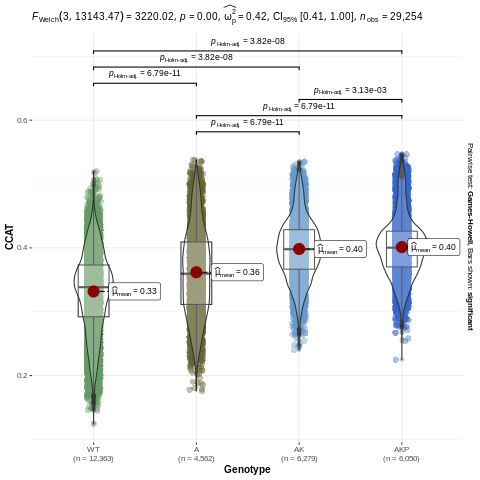

In [13]:
%%R

metadata %>% filter(batch==0) %>% mutate(Genotype = factor(Genotype, levels=c("WT","A","AK","AKP"))) %>%
ggstatsplot::ggbetweenstats(
                            x = Genotype,
                            y = CCAT,
                            type="p",
                            plot.type = "boxviolin",
                            #point.args = c(size=0)
                            ) +
scale_color_manual(values = palette_genotype) 

Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.


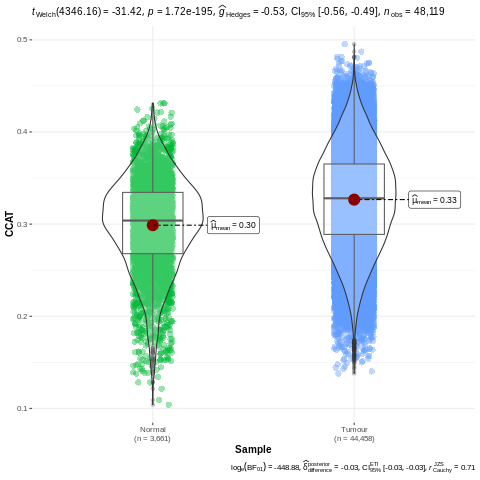

In [15]:
%%R

metadata %>% filter(batch==1) %>% filter(Sample!="LymphNode") %>% mutate(Sample = factor(Sample, levels=c("Normal","Tumour"))) %>%
ggstatsplot::ggbetweenstats(
                            x = Sample,
                            y = CCAT,
                            type="p",
                            plot.type = "boxviolin",
                            #point.args = c(size=0)
                            ) +
scale_color_manual(values = c("#00BA38","#619CFF"))

DIspersion of CCAT scores

In [159]:
%%R

std_humanCCAT %>% filter(Sample!="LymphNode") %>% mutate(Sample = factor(Sample, levels=c("Normal","Tumor"))) %>%
ggstatsplot::ggbetweenstats(
                            x = Sample,
                            y = IQR,
                            type="p",
                            plot.type = "boxviolin",
                            #point.args = c(size=0)
                            ) +
scale_color_manual(values = c("#00BA38","#619CFF")) +
theme(
    legend.position = c(.98, 1),
                            legend.justification = c("right", "top"),
                            legend.box.just = "right",
                            legend.margin = margin(6, 6, 6, 6),
                            panel.grid.major.x = element_blank()
                                ) +
    labs(title = NULL, x=NULL, y=NULL, colour="Sample")


Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.


In [173]:
%%R

std_mouseCCAT %>% mutate(Genotype = factor(Genotype, levels=c("WT","A","AK","AKP"))) %>%
ggstatsplot::ggbetweenstats(
                            x = Genotype,
                            y = IQR,
                            type="p",
                            plot.type = "boxviolin",
                            #point.args = c(size=0)
                            ) +
scale_color_manual(values = palette_genotype) +
theme(
    legend.position = c(.98, 1),
                            legend.justification = c("right", "top"),
                            legend.box.just = "right",
                            legend.margin = margin(6, 6, 6, 6),
                            panel.grid.major.x = element_blank()
                                ) +
    labs(title = NULL, x=NULL, y=NULL, colour="Genotype")


Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.
